In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize, PowerTransformer, power_transform, scale
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [86]:
## Load data
month_data_no_census = np.load('../data/covid/covid_month_no_census_filtered.npy', allow_pickle=True)
month_data_with_census = np.load('../data/covid/covid_month_with_census_filtered.npy',allow_pickle=True)
# month_data_with_census = np.loadtxt('../data/covid/covid_month_with_census_filtered.csv', delimiter=",")
print(month_data_no_census.shape, month_data_with_census.shape)
month_data_df = pd.read_csv('../data/covid/covid_month.csv')
month_data_df.head()

(312, 5) (312, 172)


,Unnamed: 0,month,region,cases
0,0,3,Acton,0
1,1,3,Adams-Normandie,5
2,2,3,Agoura Hills,56
3,3,3,Alhambra,90
4,4,3,Alsace,0


In [68]:
census_data = pd.read_csv('../data/social_explorer_processed_data_only_percents.csv')
feature_names = np.concatenate((['cases', 'Neighbor cases', 'County total cases'], census_data.columns.values[1:]))
feature_names

array(['cases', 'Neighbor cases', 'County total cases',
       '% Area Total: Area (Land)', '% Area Total: Area (Water)',
       '% Total Population: Under 5 Years',
       '% Total Population: 5 to 9 Years',
       '% Total Population: 10 to 14 Years',
       '% Total Population: 15 to 17 Years',
       '% Total Population: 18 to 24 Years',
       '% Total Population: 25 to 34 Years',
       '% Total Population: 35 to 44 Years',
       '% Total Population: 45 to 54 Years',
       '% Total Population: 55 to 64 Years',
       '% Total Population: 65 to 74 Years',
       '% Total Population: 75 to 84 Years',
       '% Total Population: 85 Years and Over',
       '% Households: Family Households',
       '% Households: Family Households: Married-Couple Family',
       '% Households: Family Households: Other Family',
       '% Households: Family Households: Other Family: Male Householder, No Wife Present',
       '% Households: Family Households: Other Family: Female Householder, No Husban

# Naive train-test split

In [9]:
month_no_census_X = month_data_no_census[:, 1:]
month_no_census_X = month_no_census_X[:,:-1]
month_no_census_y = month_data_no_census[:, -1]

month_with_census_X = month_data_with_census[:, 1:]
month_with_census_X = month_with_census_X[:,:-1]
month_with_census_y = month_data_with_census[:, -1]

print(month_no_census_X.shape, month_with_census_X.shape)

(312, 3) (312, 170)


In [10]:
month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test = train_test_split(
    month_no_census_X, month_no_census_y, test_size=0.4, random_state=42)
month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = train_test_split(
    month_with_census_X, month_with_census_y, test_size=0.4, random_state=42)

# Time Validation

In [3]:
def transform_data(data):
    pt = PowerTransformer()
    if len(data.shape) == 1:
        transformed_data = pt.fit_transform(data.reshape(-1,1))
        return (transformed_data.reshape(-1,), pt)
    transformed_data = pt.fit_transform(data)
    return (transformed_data, pt)
def apply_transform(model, data):
    if len(data.shape) == 1:
        return model.transform(data.reshape(-1,1)).reshape(-1,)
    return model.transform(data)

In [4]:
def one_time_split(data):
    # Index of first row with month == 4
    first_index = np.where(data[:,0]==4)[0][0]
    print(first_index)
    # Index of first row with month == 8
    last_index = np.where(data[:,0] == 8)[0][0]
    
    # Split into train test
    X_train = data[first_index:last_index, 1:-1]
    X_test = data[last_index:, 1:-1]
    y_train = data[first_index:last_index, -1]
    y_test = data[last_index:, -1]
    
    # Feature transformation
    ## Transformation should be done on the training set and applied on testing set
    X_train, pt_X = transform_data(X_train)
    X_test = apply_transform(pt_X, X_test)
    y_train, pt_y = transform_data(y_train)
    y_test = apply_transform(pt_y, y_test)
    
    return(X_train,X_test,y_train,y_test)

In [5]:
def multiple_time_split(data):
    X_train_arr = []
    X_test_arr = []
    y_train_arr = []
    y_test_arr = []
    for i in range(4,7):
        train_start_index = np.where(data[:,0]==i)[0][0]
        test_start_index = np.where(data[:,0]==i+2)[0][0]
        test_end_index = np.where(data[:,0]==i+3)[0][0] if i!=6 else data.shape[0]
        X_train = data[train_start_index:test_start_index, 1:-1]
        X_test = data[test_start_index:test_end_index, 1:-1]
        y_train = data[train_start_index:test_start_index, -1]
        y_test = data[test_start_index:test_end_index, -1]
        
        print('============')
        print(train_start_index, test_start_index, test_end_index)
        print('============')
        
        # Feature transformation
        ## Transformation should be done on the training set and applied on testing set
        X_train, pt_X = transform_data(X_train)
        X_test = apply_transform(pt_X, X_test)
        y_train, pt_y = transform_data(y_train)
        y_test = apply_transform(pt_y, y_test)
        
        X_train_arr.append(X_train)
        X_test_arr.append(X_test)
        y_train_arr.append(y_train)
        y_test_arr.append(y_test)
        
    return (X_train_arr, X_test_arr, y_train_arr, y_test_arr)

In [6]:
month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test = one_time_split(
    month_data_no_census)
print(month_no_census_X_test.shape)

52
(52, 3)


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [7]:
month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test = one_time_split(
    month_data_with_census)
print(month_with_census_X_test.shape)

52
(52, 170)


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [8]:
month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr = multiple_time_split(
    month_data_no_census)
print(month_no_census_X_train_arr[1].shape)

52 156 208
104 208 260
156 260 312
(104, 3)


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [9]:
month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr = multiple_time_split(
    month_data_with_census)
print(month_with_census_X_train_arr[2].shape)

52 156 208
104 208 260


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/jackiedon

156 260 312
(104, 170)


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


# Model Training

In [10]:
def one_split_model(X_train, X_test, y_train, y_test, model, graph_title):
    # Error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    error = {
        'mse': mse,
        'r2': r2,
        'mae': mae
    }
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse, b=r2, c=mae, d=np.average(y_test)))
    
    # Graph
    fig, ax = plt.subplots(figsize=[8,6])
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(graph_title)
    plt.show()
#     print(sorted(model.cv_results_.keys()))
    return {
        'error': error    
    }


In [106]:
def multiple_split_model(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title):
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(model.predict(X_test_arr[i]))
        mse_arr.append(mean_squared_error(y_pred_arr[i], y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], y_test_arr[i]))
        avg_arr.append(np.average(y_test_arr[i]))
        
#         feat_im = np.array(model.feature_importances_)
#         feat_im_indices = feat_im.argsort()[-10:]
#         important_features = feature_names[feat_im_indices]
#         plt.figure()
#         plt.title("Feature importances")
#         plt.barh(range(len(important_features)), feat_im[feat_im_indices],
#                color="r", align="center")
#         plt.yticks(range(len(important_features)), important_features)
#         plt.ylim([-1, len(important_features)])
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr))
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(y_test_arr[i], y_pred_arr[i])
        axs[i].plot([y_test_arr[i].min(), y_test_arr[i].max()], [y_test_arr[i].min(), y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for test set in month {m}'.format(m=i+6))
    fig.suptitle(graph_title, fontsize=16)
    plt.show()

# Linear Reg

In [12]:
lin_model = LinearRegression()

MSE: 0.4336198129186522 
r2: 0.40864091388834867 
MAE: 0.6095860582112475 
avg: -0.3739842107738299


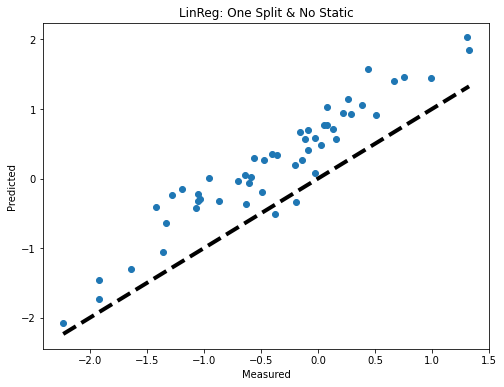

{'error': {'mse': 0.4336198129186522,
  'r2': 0.40864091388834867,
  'mae': 0.6095860582112475}}

In [98]:
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, lin_model, "LinReg: One Split & No Static")

MSE: 0.33737727054891953 
r2: 0.6446120186229712 
MAE: 0.5001102278560359 
avg: -0.3739842107738299


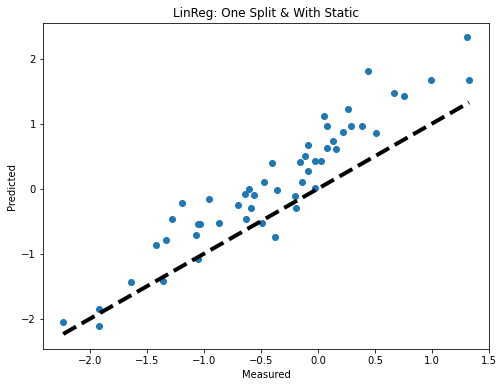

{'error': {'mse': 0.33737727054891953,
  'r2': 0.6446120186229712,
  'mae': 0.5001102278560359}}

In [99]:
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, lin_model, "LinReg: One Split & With Static")

MSE: [0.08913651877125459, 0.5276616119566436, 0.6987869289863702] 
r2: [0.9275278262973917, 0.504934226983365, 0.10058812602812928] 
MAE: [0.22897807195976377, 0.6840613258007784, 0.788039800122318] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


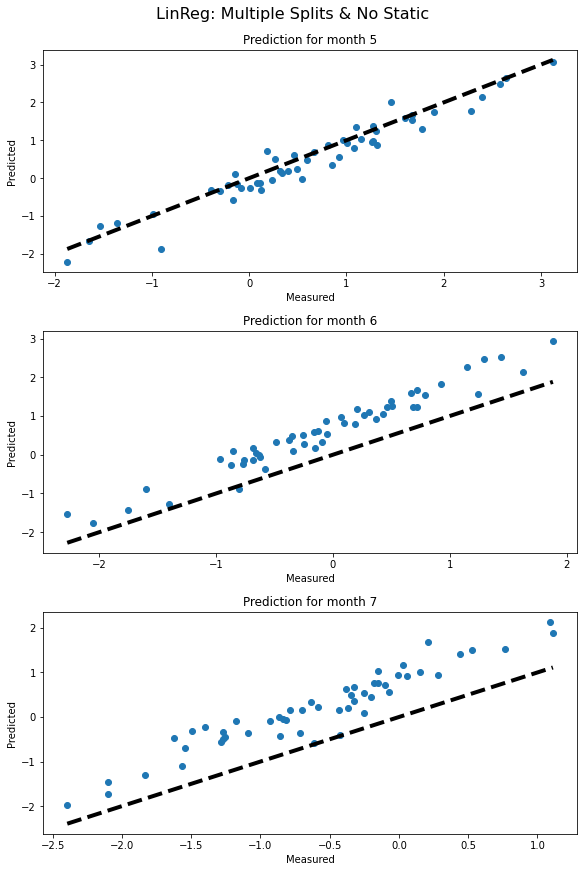

In [100]:
multiple_split_model(month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr, lin_model, "LinReg: Multiple Splits & No Static")

In [ ]:
multiple_split_model(month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr, lin

MSE: [0.2685470862217881, 0.4383870889767415, 0.6211436916681781] 
r2: [0.7775325488213707, 0.6064277913127942, 0.3633358490428322] 
MAE: [0.4334074115022656, 0.5831826408741063, 0.7051490270977834] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


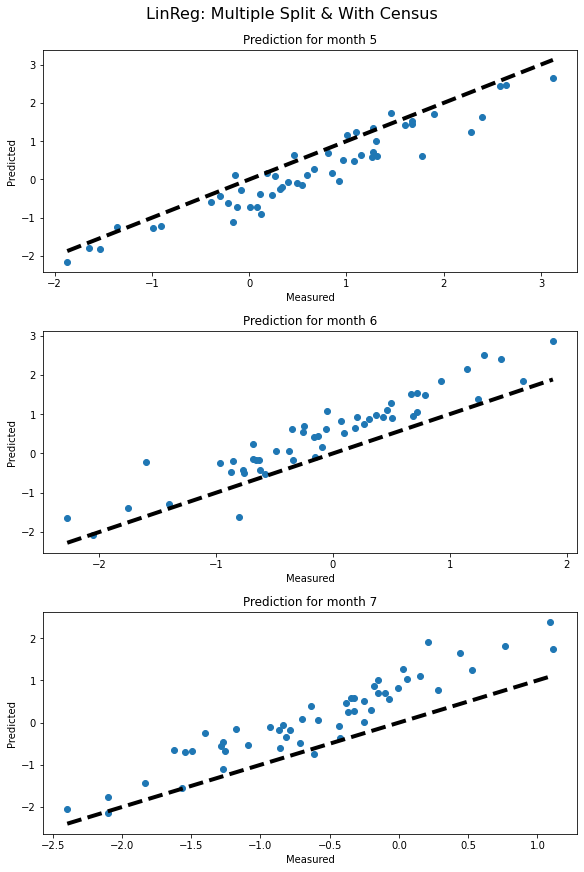

In [18]:
multiple_split_model(month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr, lin_model, "LinReg: Multiple Split & With Census")

# SVR

In [101]:
# svr_params = {
#     'C': 10,
# }

svr_params = {
    'C': 10,
    'gamma': 0.01,
}

svr_param_grid = {
    'C':[10, 100, 1000, 10000],
    "gamma": [1e-4, 1e-3, 1e-2, 1e-1, 1],
    'kernel': ['poly'],
    'degree':[3,5,7]
}

svr_model = SVR(**svr_params)
svr_search = GridSearchCV(svr_model, svr_param_grid)

MSE: 0.42440769881363194 
r2: 0.40218282396275284 
MAE: 0.5960223939527841 
avg: -0.3739842107738299


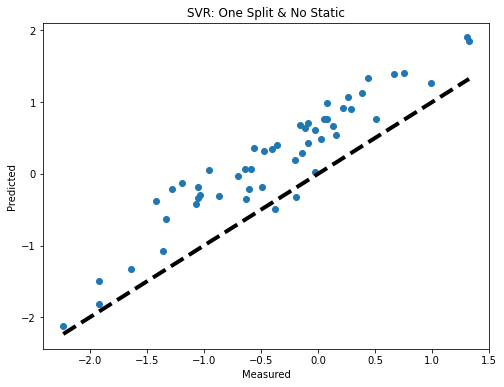

{'error': {'mse': 0.42440769881363194,
  'r2': 0.40218282396275284,
  'mae': 0.5960223939527841}}

In [102]:
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, svr_model, "SVR: One Split & No Static")

In [43]:
svr_search.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

MSE: 0.2863344327676421 
r2: 0.6708431138385504 
MAE: 0.4662918122064111 
avg: -0.3739842107738299


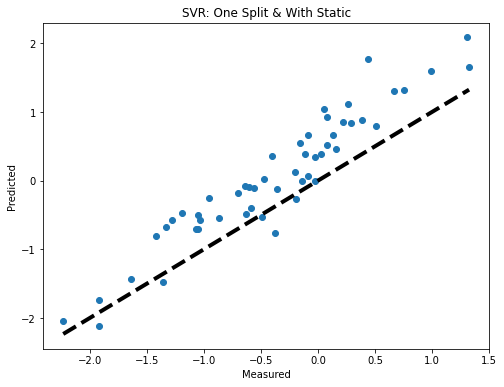

{'error': {'mse': 0.2863344327676421,
  'r2': 0.6708431138385504,
  'mae': 0.4662918122064111}}

In [103]:
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, svr_model, "SVR: One Split & With Static")

In [290]:
svr_search.best_estimator_

SVR(C=1000, gamma=0.0001)

MSE: [0.08305011728011848, 0.5512555347898523, 0.7441026197958445] 
r2: [0.926469974856053, 0.4700198131489127, 0.14081216366858407] 
MAE: [0.2379545858804664, 0.7023048976346978, 0.8078096085561272] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


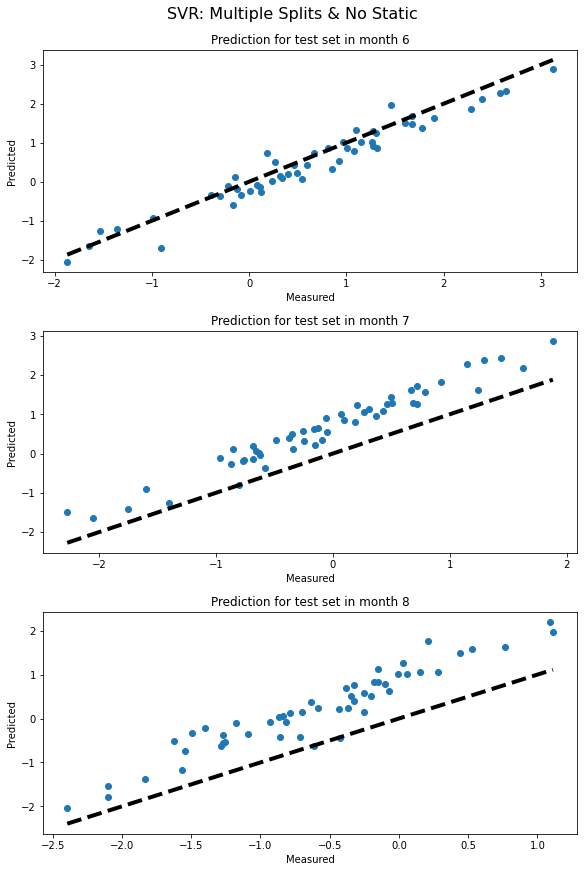

In [107]:
multiple_split_model(month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr, svr_model, "SVR: Multiple Splits & No Static")

In [108]:
svr_search.best_estimator_

SVR(C=10000, gamma=0.001, kernel='poly')

MSE: [0.34843610231636646, 0.34126418636241806, 0.6734113707481776] 
r2: [0.7128944116456397, 0.6693035049224295, 0.30267849815595516] 
MAE: [0.4772015440292416, 0.49341897641937543, 0.732137096231348] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


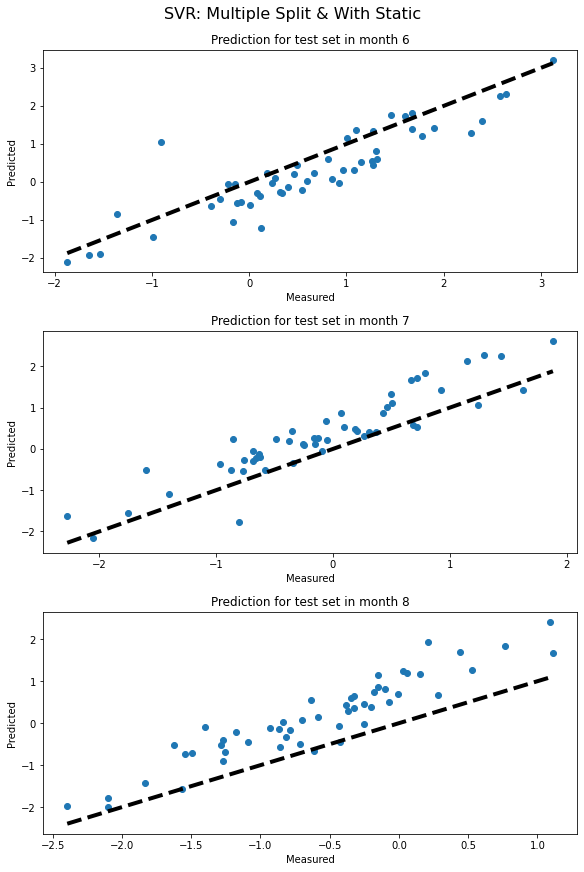

In [109]:
multiple_split_model(month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr, svr_search, "SVR: Multiple Split & With Static")

# Gradient Boosting

In [58]:
gb_param_grid = {
   'n_estimators': [700, 900, 1100],
    'max_depth': [16, 32, 48],
    'min_samples_split': [50, 100, 200],
}

gb_model = GradientBoostingRegressor()
gb_search = GridSearchCV(gb_model, gb_param_grid)

In [64]:
gb_param = {
    'n_estimators': 700,
    'max_depth': 16,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}

In [51]:
new_m = GradientBoostingRegressor(**gb_param)

## One split

### No census

MSE: 0.4471286572051385 
r2: 0.3822304958273032 
MAE: 0.5917919193393463 
avg: -0.3739842107738299


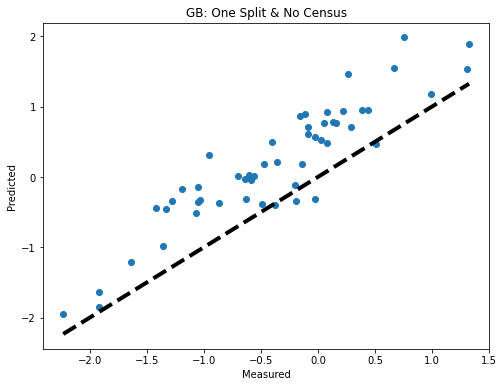

{'error': {'mse': 0.4471286572051385,
  'r2': 0.3822304958273032,
  'mae': 0.5917919193393463}}

In [66]:
gb_model = GradientBoostingRegressor(**gb_param)
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, gb_model, "GB: One Split & No Census")

### With census

MSE: 0.39093595055103286 
r2: 0.5810567359230666 
MAE: 0.5396499566995068 
avg: -0.3739842107738299


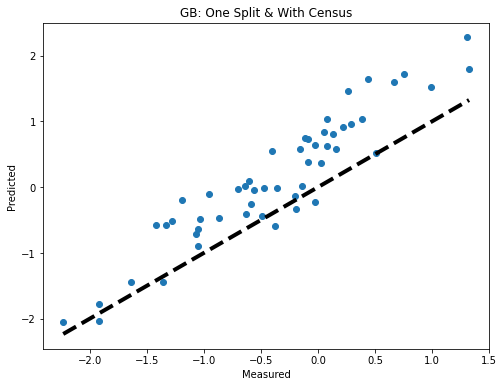

{'error': {'mse': 0.39093595055103286,
  'r2': 0.5810567359230666,
  'mae': 0.5396499566995068}}

In [70]:
gb_model = GradientBoostingRegressor(**gb_param)
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, gb_model, "GB: One Split & With Census")

In [60]:
gb_search.best_estimator_

GradientBoostingRegressor(max_depth=48, min_samples_split=100, n_estimators=700)

cases
0.8505016368878853
County total cases
0.06915929360298233
% Households: Family Households: Other Family: Male Householder, No Wife Present
0.020919556969336634
% Population for Whom Poverty Status Is Determined: 1.50 to 1.99
0.012425143966086575
% Total Population: 18 to 24 Years
0.008351114222901053
% Households10: 5-Person Household
0.005855205717869056
% Households10: 3-Person Household
0.005280652063711817
% Workers 16 Years and Over2: Did Not Work At Home
0.0038077916198482865
% Workers 16 Years and Over: Worked At Home
0.0031936873441806807
% Households2: No Wage or Salary Income
0.003046599608985578


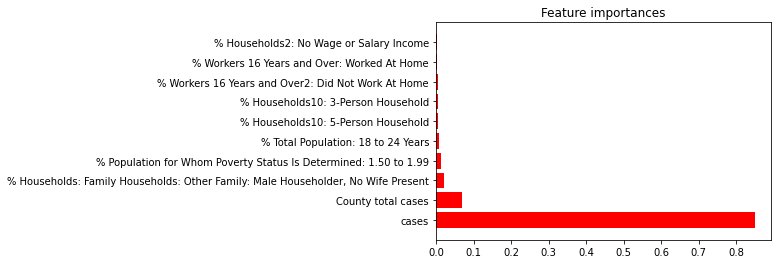

In [116]:
feat_im = np.array(gb_model.feature_importances_)
feat_im_indices = feat_im.argsort()[-10:][::-1]
important_features = feature_names[feat_im_indices]
for i in feat_im_indices:
    print(feature_names[i])
    print(feat_im[i])

plt.figure()
plt.title("Feature importances")
plt.barh(range(len(important_features)), feat_im[feat_im_indices],
       color="r", align="center")
plt.yticks(range(len(important_features)), important_features)
plt.ylim([-1, len(important_features)])
plt.show()

## Multiple Splits

### No census

MSE: [0.1396776884813398, 0.49108492288644506, 0.6505869008986379] 
r2: [0.8757722622707025, 0.5157347066685312, -0.033791348813180244] 
MAE: [0.29126834048662, 0.6456543026123218, 0.7638755275537535] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


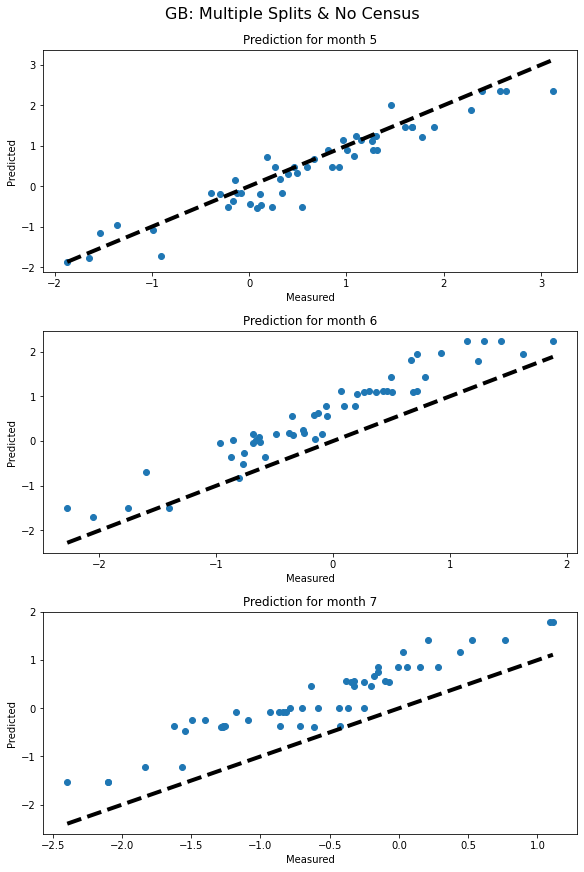

In [72]:
multiple_split_model(month_no_census_X_train_arr, month_no_census_X_test_arr, month_no_census_y_train_arr, month_no_census_y_test_arr, gb_model, "GB: Multiple Splits & No Census")

### With census

MSE: [0.174185449599899, 0.404999947188759, 0.6266623315090942] 
r2: [0.8305526189698794, 0.6432497634835395, 0.05413169862945766] 
MAE: [0.3301238603573808, 0.575914919185969, 0.7444919557602921] 
avg: [0.623485276239814, -0.08007015087965146, -0.5968368628680277]


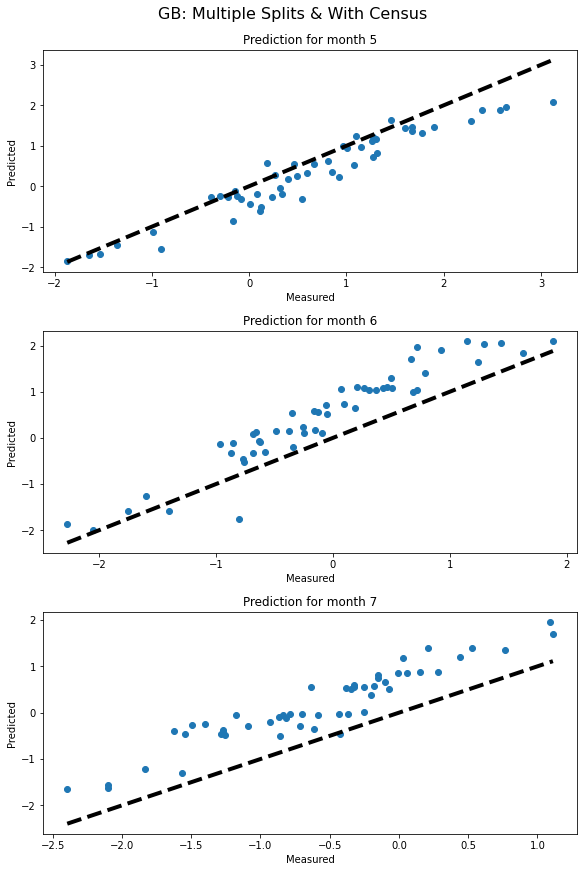

In [73]:
multiple_split_model(month_with_census_X_train_arr, month_with_census_X_test_arr, month_with_census_y_train_arr, month_with_census_y_test_arr, gb_model, "GB: Multiple Splits & With Census")

# XGBoost

In [25]:
!pip install xgboost

     |████████████████████████████████| 1.2 MB 6.1 MB/s eta 0:00:01


In [8]:
from xgboost import XGBRegressor

In [273]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)

[18:15:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE: 0.4554798193564229 
r2: 0.39385516339031 
MAE: 0.6062499816116015 
avg: -0.3739842107738299


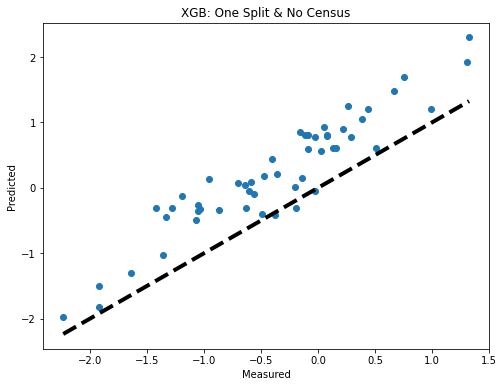

{'error': {'mse': 0.4554798193564229,
  'r2': 0.39385516339031,
  'mae': 0.6062499816116015}}

In [274]:
one_split_model(month_no_census_X_train, month_no_census_X_test, month_no_census_y_train, month_no_census_y_test, xg_model, "XGB: One Split & No Census")

[18:16:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { loss, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE: 0.4008754612627419 
r2: 0.5597177196875182 
MAE: 0.5529300058128805 
avg: -0.3739842107738299


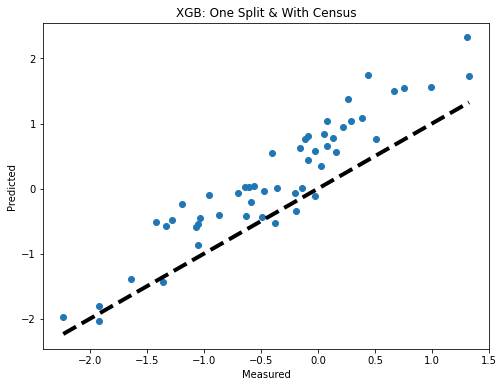

{'error': {'mse': 0.4008754612627419,
  'r2': 0.5597177196875182,
  'mae': 0.5529300058128805}}

In [275]:
one_split_model(month_with_census_X_train, month_with_census_X_test, month_with_census_y_train, month_with_census_y_test, xg_model, "XGB: One Split & With Census")

# Scratch Work

skewness: 3.0004990870073462


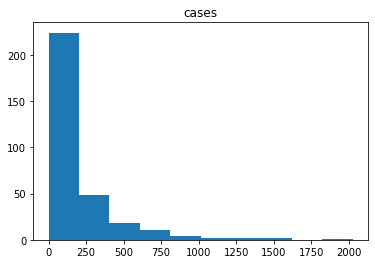

###### Transform
yeo-johnson: -0.04661541673327372
log: -0.609601276069952


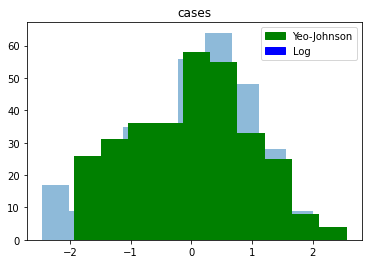

skewness: 2.071711837966126


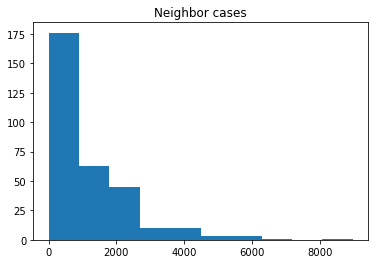

###### Transform
yeo-johnson: -0.12236585943666693
log: -0.9784020275078388


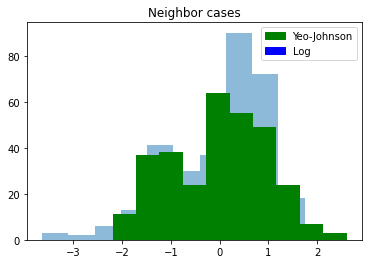

skewness: -2.862430682945693


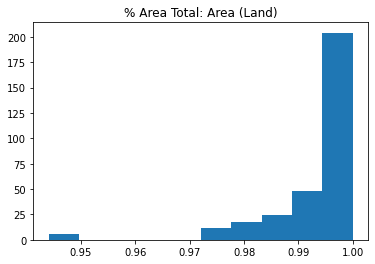

###### Transform
yeo-johnson: -0.6213104862618
log: -2.893558265992476


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


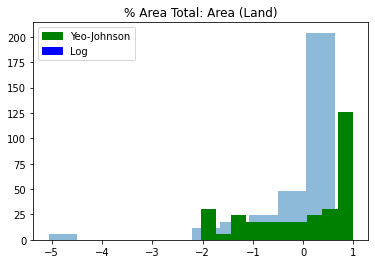

skewness: 2.8624337597690315


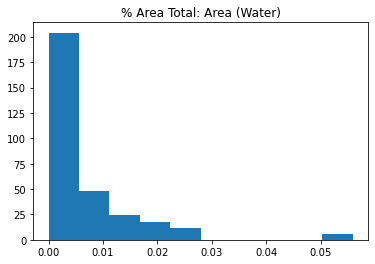

###### Transform
yeo-johnson: 1.823837211484904
log: 2.8032882791288984


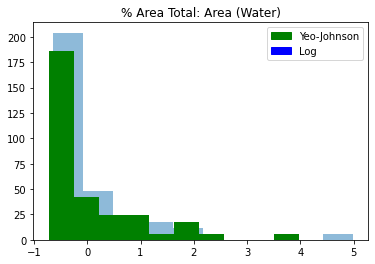

skewness: 1.071924222552087


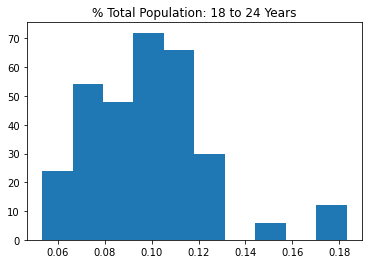

###### Transform
yeo-johnson: -0.004375634746533622
log: 0.9684450155987084


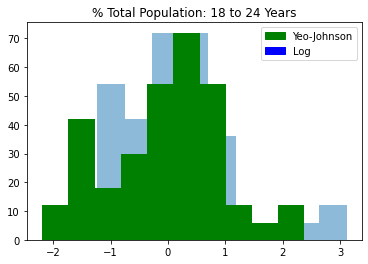

skewness: 1.3402287642360038


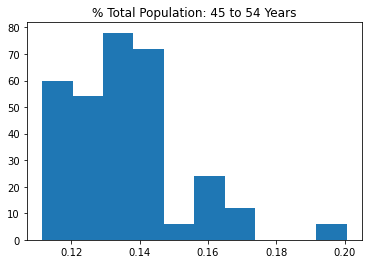

###### Transform
yeo-johnson: 0.23689397177706076
log: 1.2736914594000952


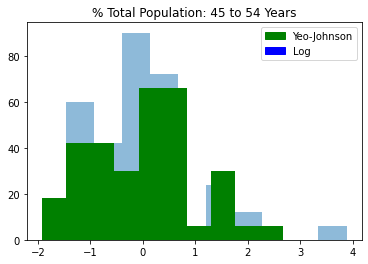

skewness: 2.12047639537729


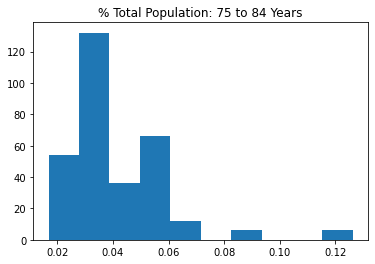

###### Transform
yeo-johnson: 0.0
log: 2.0097167602845483


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


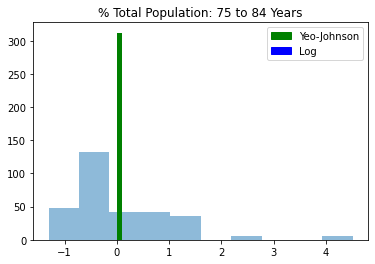

skewness: 4.443169032235253


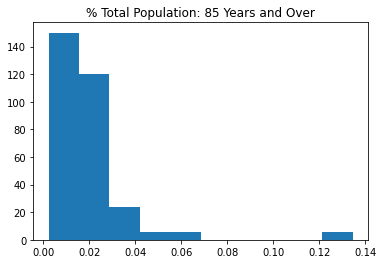

###### Transform
yeo-johnson: 0.0
log: 4.286949964512539


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


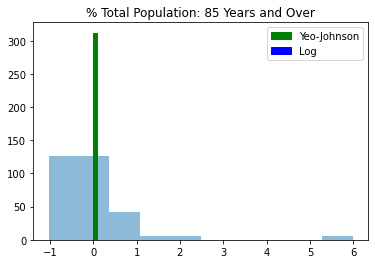

skewness: -2.109736182954799


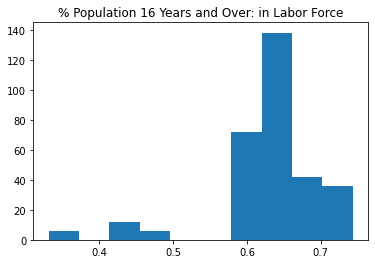

###### Transform
yeo-johnson: 0.06372473838536401
log: -2.3222354798000118


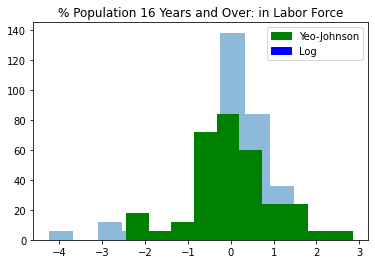

skewness: 3.208817881012847


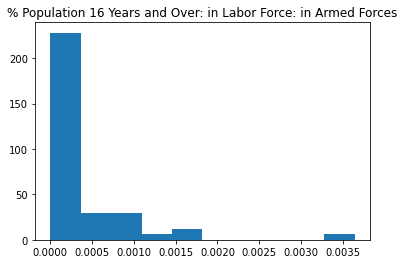

###### Transform
yeo-johnson: 3.236048057112391
log: 3.2046897982711937


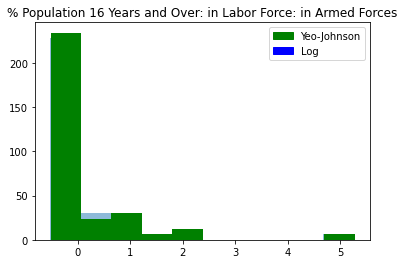

skewness: -2.1065068281417823


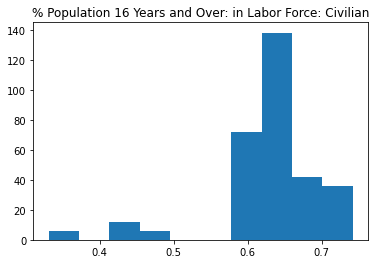

###### Transform
yeo-johnson: 0.06034843604030452
log: -2.319210839943798


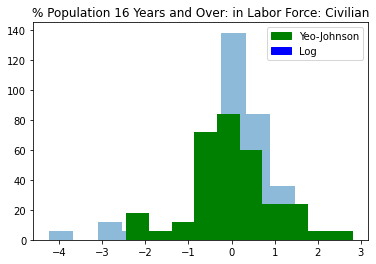

skewness: -2.056109472648523


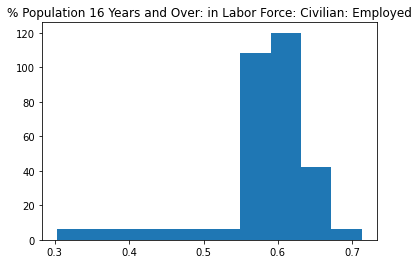

###### Transform
yeo-johnson: 0.1699922802031304
log: -2.2807942254410607


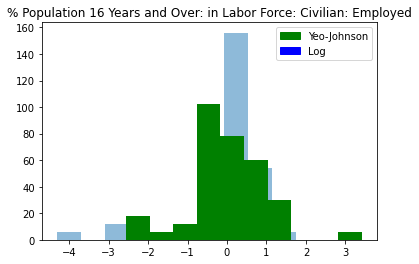

skewness: 2.109736182954801


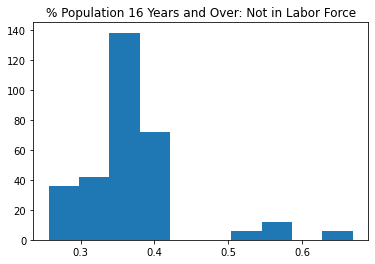

###### Transform
yeo-johnson: -0.0852183604501643
log: 1.8785894750081522


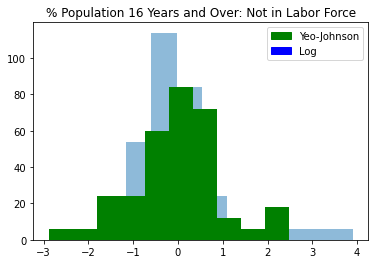

skewness: 3.3161401116250304


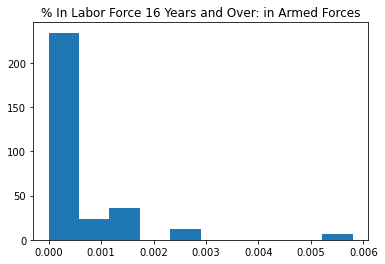

###### Transform
yeo-johnson: 3.396120227210824
log: 3.309457350307325


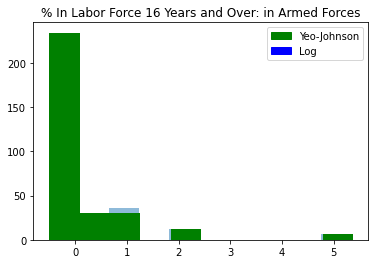

skewness: -3.31614011610819


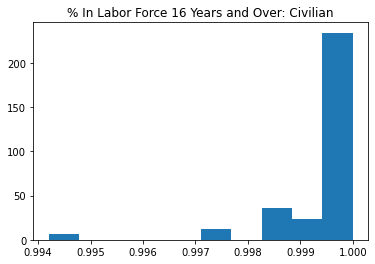

###### Transform
yeo-johnson: -2.657819873785091
log: -3.319497970853072


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2960: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


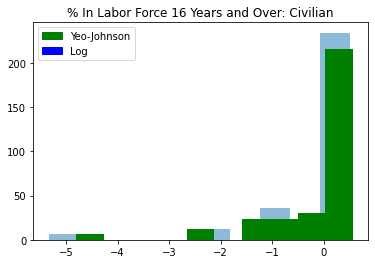

skewness: 1.9749541995073305


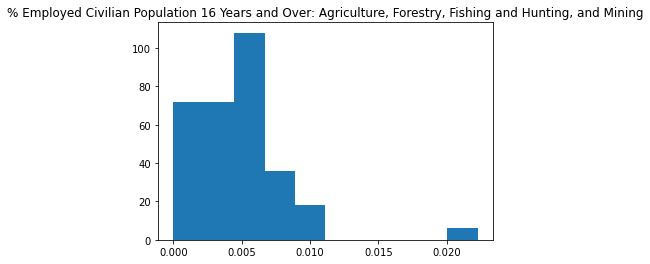

###### Transform
yeo-johnson: 0.0
log: 1.9437641751311905


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


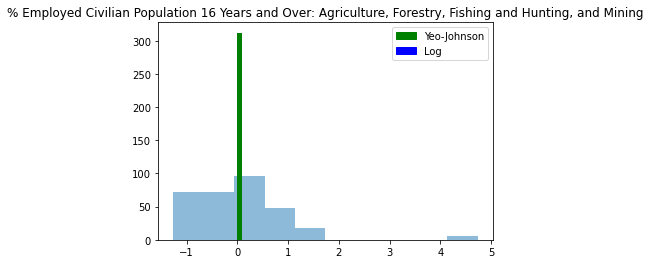

skewness: -1.0217142619353266


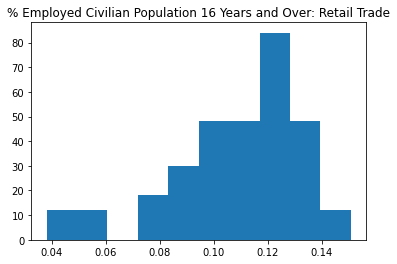

###### Transform
yeo-johnson: -0.03688730166833334
log: -1.081775451844084


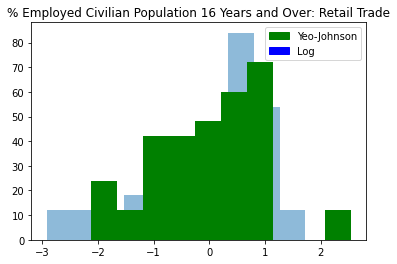

skewness: 1.2676707883356786


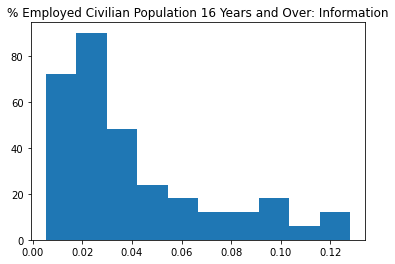

###### Transform
yeo-johnson: 0.0
log: 1.2211756535094533


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


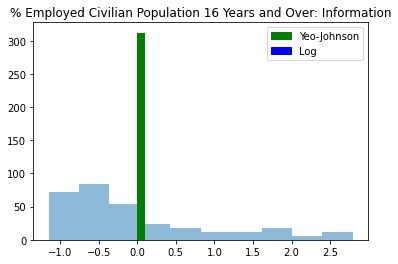

skewness: 1.8250343028324312


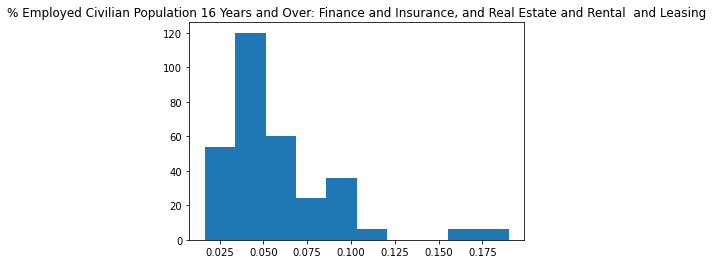

###### Transform
yeo-johnson: 0.12419844457960148
log: 1.696048680143596


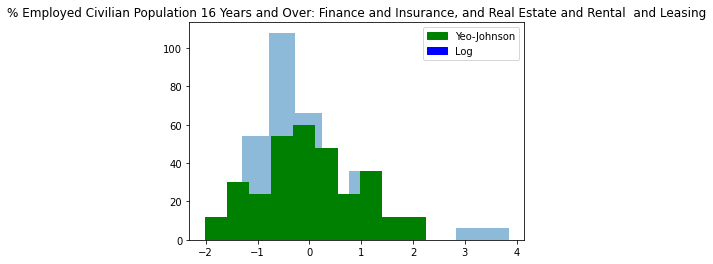

skewness: 1.114121723554344


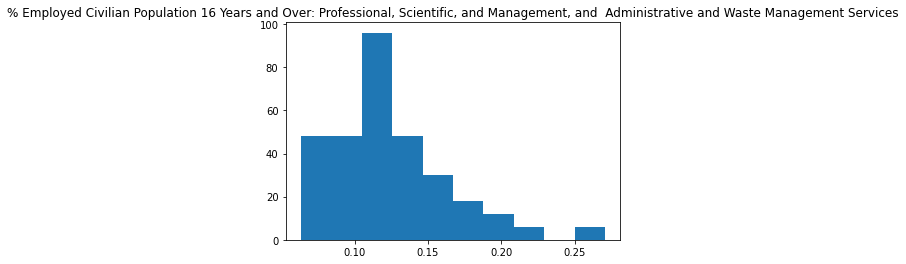

###### Transform
yeo-johnson: 0.03195339674115683
log: 0.9763658476047965


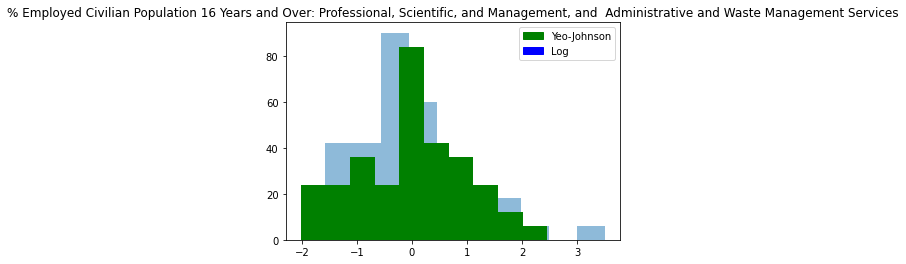

skewness: 1.0919974662205936


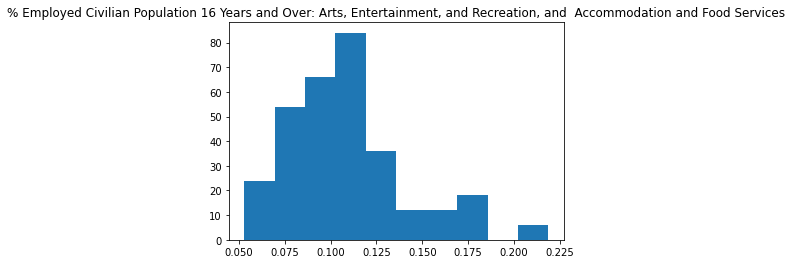

###### Transform
yeo-johnson: 0.06240381669918332
log: 1.006067622685028


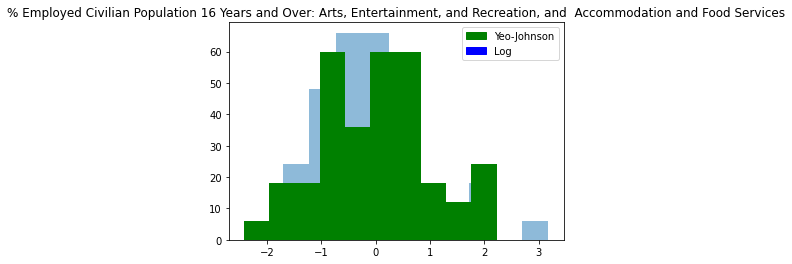

skewness: 1.7084749499301937


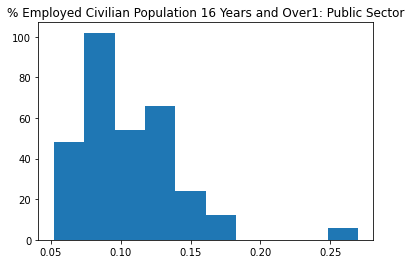

###### Transform
yeo-johnson: 0.04177114726132402
log: 1.5010544509669355


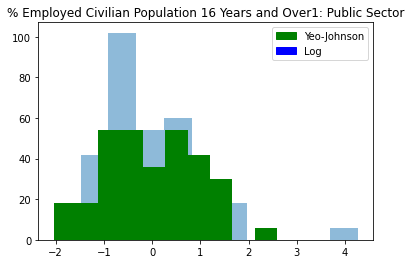

skewness: 1.3946108511846378


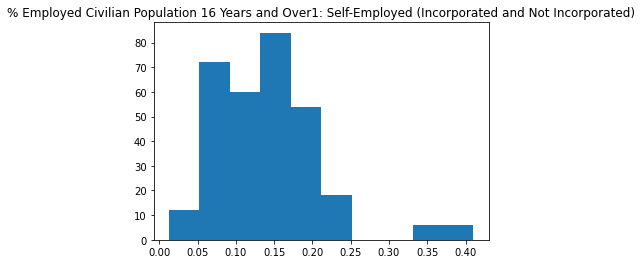

###### Transform
yeo-johnson: -0.023153621698889803
log: 1.0931424732667612


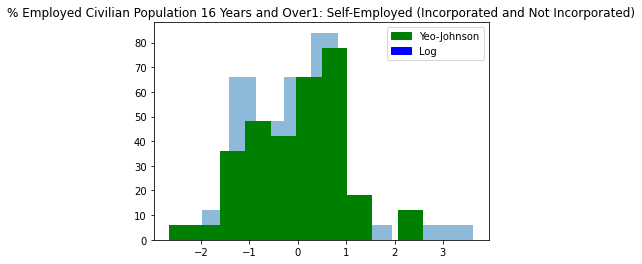

skewness: 3.0438196663287074


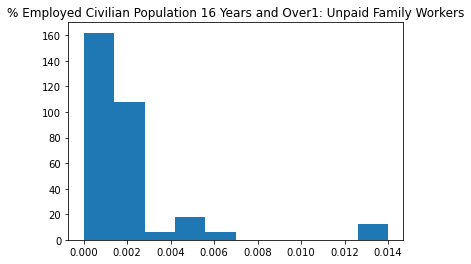

###### Transform
yeo-johnson: 0.0
log: 3.0318961674015483


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


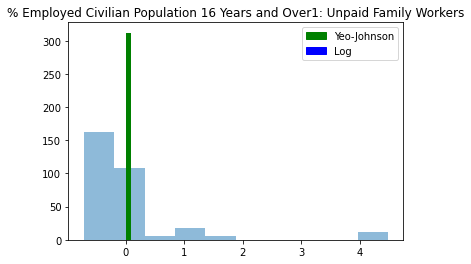

skewness: -2.1555862160635293


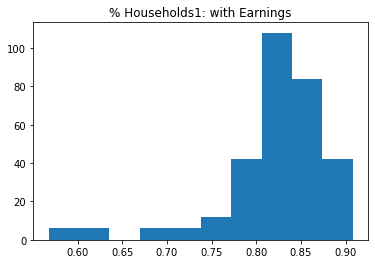

###### Transform
yeo-johnson: -0.027683848956624287
log: -2.324879997575052


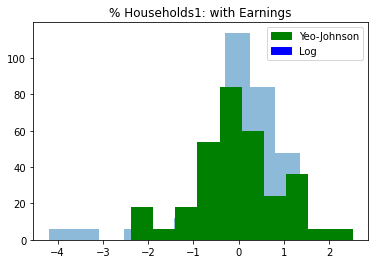

skewness: 2.1555862161021015


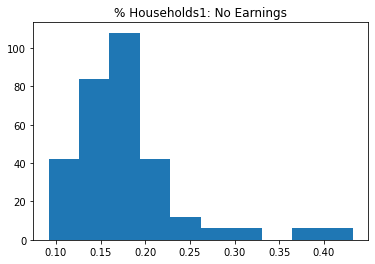

###### Transform
yeo-johnson: 0.004235320564293099
log: 1.9187574824807263


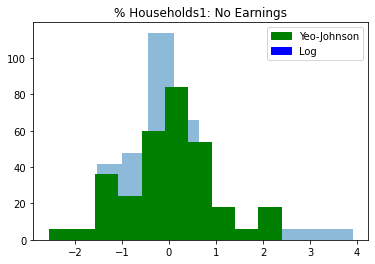

skewness: -1.2567780133469906


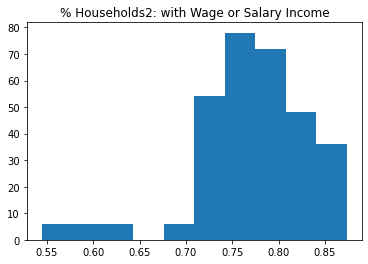

###### Transform
yeo-johnson: 0.03280516845247175
log: -1.4428585504565805


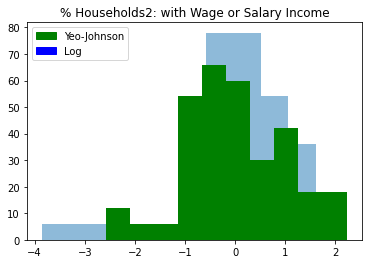

skewness: 1.2567780133469877


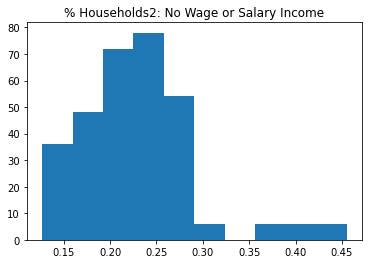

###### Transform
yeo-johnson: -0.03280369001733555
log: 1.0150448187615122


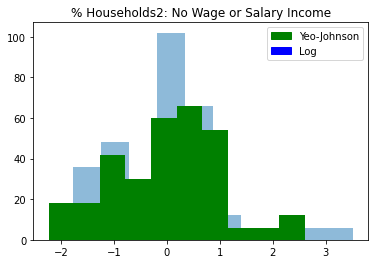

skewness: 1.5958584688507018


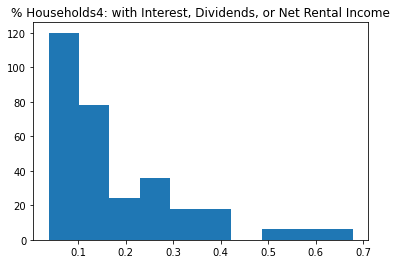

###### Transform
yeo-johnson: 0.2805290902651636
log: 1.2963648178056548


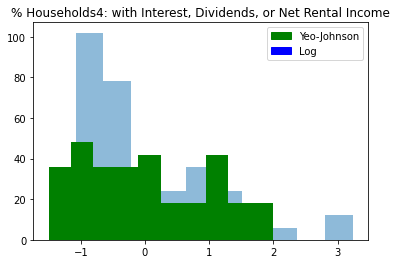

skewness: -1.5958584687497301


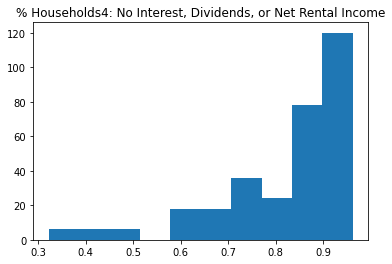

###### Transform
yeo-johnson: -0.33864865260187277
log: -1.86417017980852


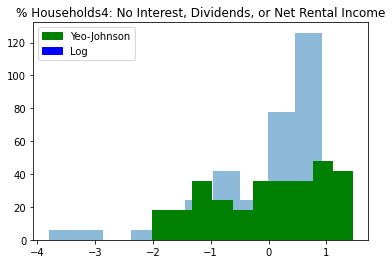

skewness: 1.0307460848336876


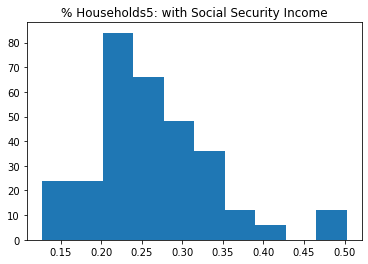

###### Transform
yeo-johnson: 0.009367620493605636
log: 0.8220317785247636


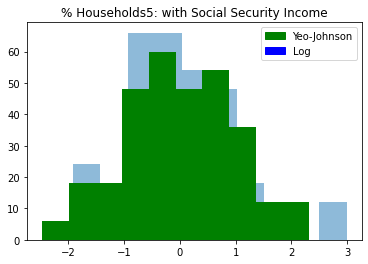

skewness: -1.0307460848336831


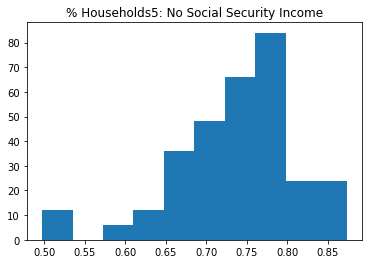

###### Transform
yeo-johnson: -0.020135609278849227
log: -1.2000550089776774


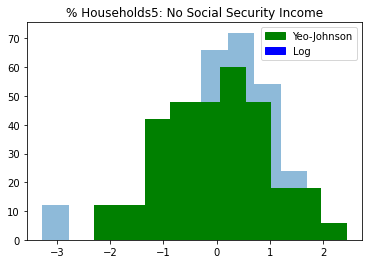

skewness: 2.2229264300875813


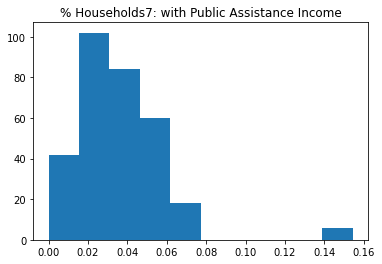

###### Transform
yeo-johnson: -0.029292502331398584
log: 2.025209058310371


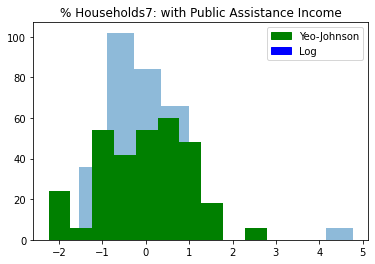

skewness: -2.2229264282111987


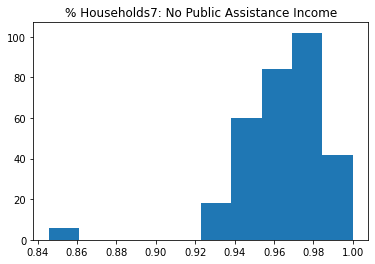

###### Transform
yeo-johnson: 0.02440135092593387
log: -2.3362062346769323


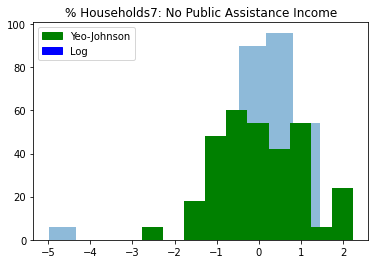

skewness: 1.0415361551742852


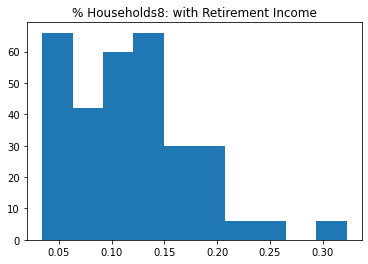

###### Transform
yeo-johnson: 0.049562962097141276
log: 0.8580954568916561


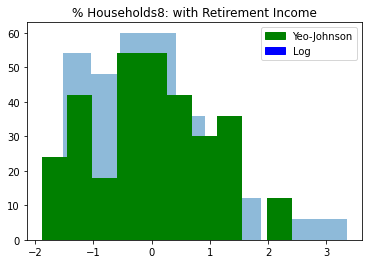

skewness: -1.0415361552199924


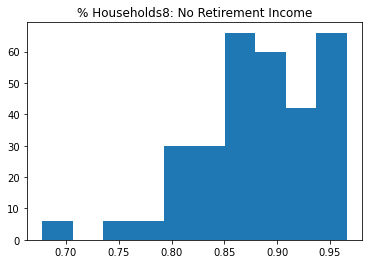

###### Transform
yeo-johnson: -0.05979548228452474
log: -1.1659373256417767


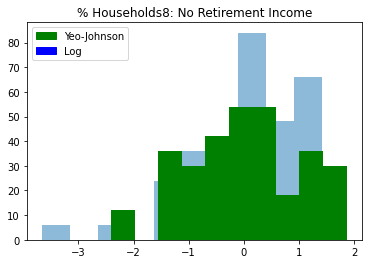

skewness: 3.25182237225599


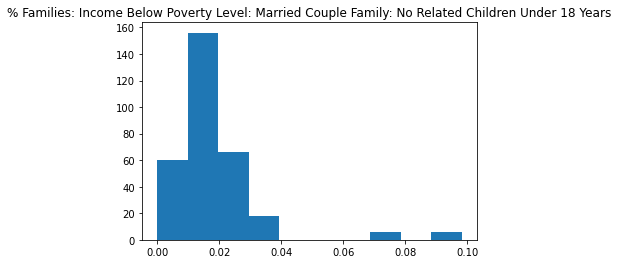

###### Transform
yeo-johnson: 1.0991961775055323
log: 3.1530806319173452


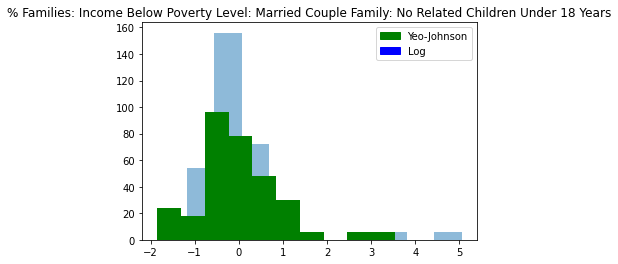

skewness: 1.489900210745963


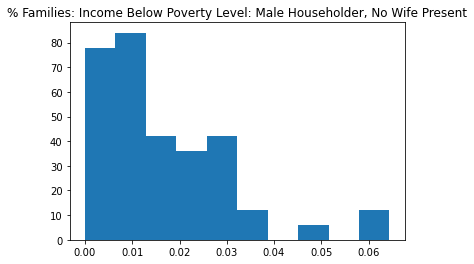

###### Transform
yeo-johnson: 0.0
log: 1.4403155158834573


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


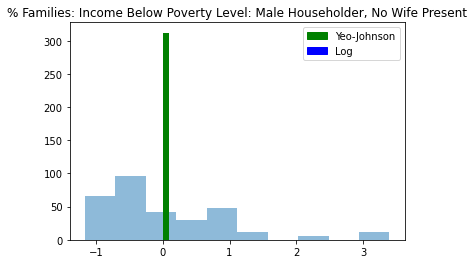

skewness: 1.1122011627382375


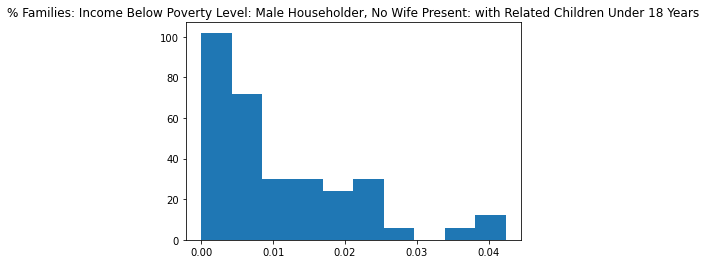

###### Transform
yeo-johnson: 0.0
log: 1.0887684645192142


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


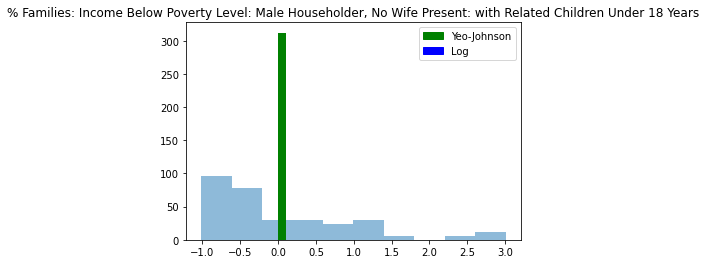

skewness: 2.0437576851949366


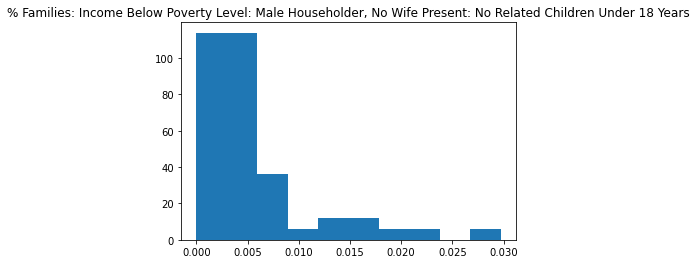

###### Transform
yeo-johnson: 0.0
log: 2.0254159730397023


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


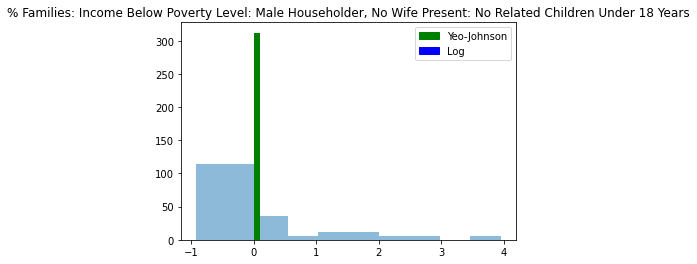

skewness: 1.306049608174209


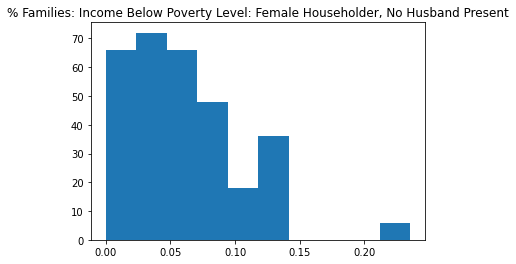

###### Transform
yeo-johnson: 0.1373379376735511
log: 1.1504080143937074


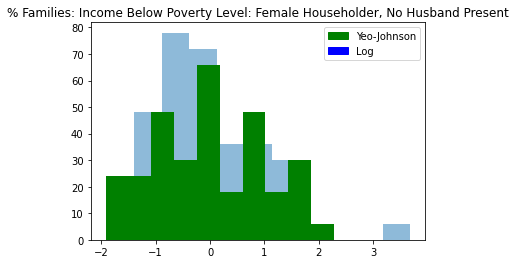

skewness: 1.5637955774798673


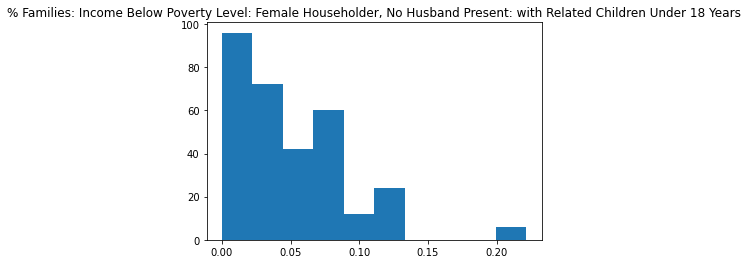

###### Transform
yeo-johnson: 0.14701591436066025
log: 1.3832038138274954


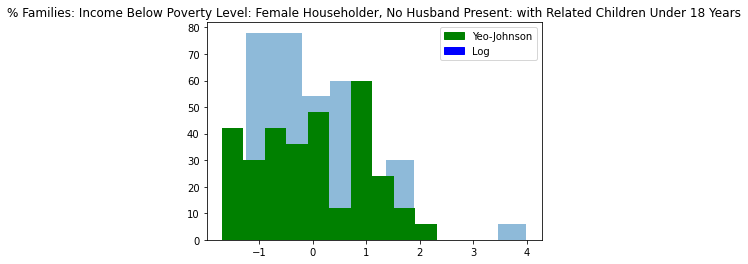

skewness: 1.4217798086872857


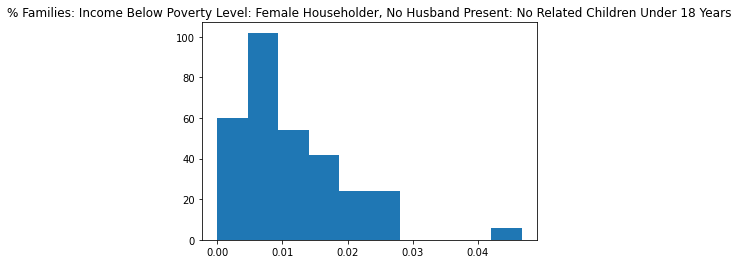

###### Transform
yeo-johnson: 0.0
log: 1.3791795231952824


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


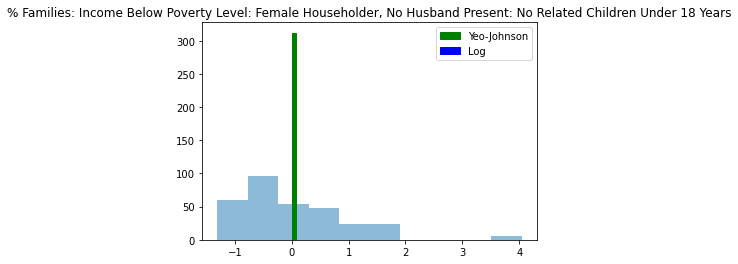

skewness: 1.4132774803939905


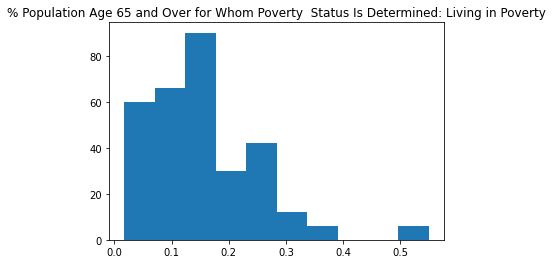

###### Transform
yeo-johnson: 0.038127687272545126
log: 1.0340690312989917


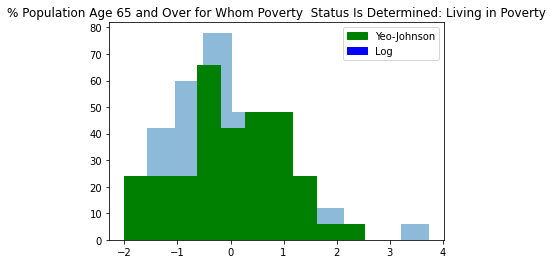

skewness: -1.4132774802961785


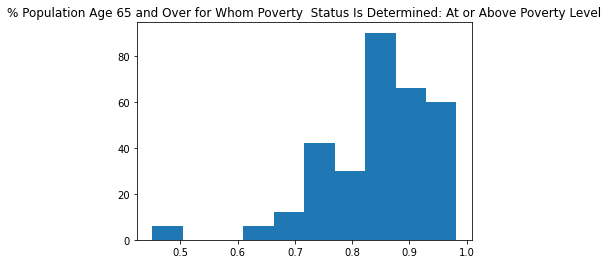

###### Transform
yeo-johnson: -0.05817885953643855
log: -1.7312760450779434


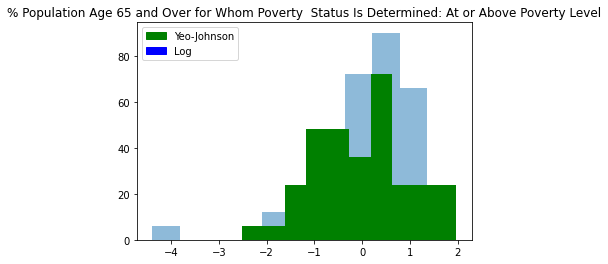

skewness: 2.49921213400391


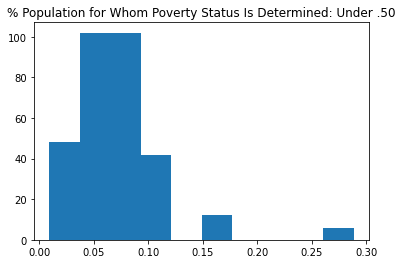

###### Transform
yeo-johnson: -0.012054733881595104
log: 2.199612685088216


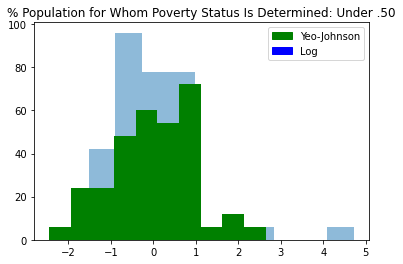

skewness: 1.702312658205241


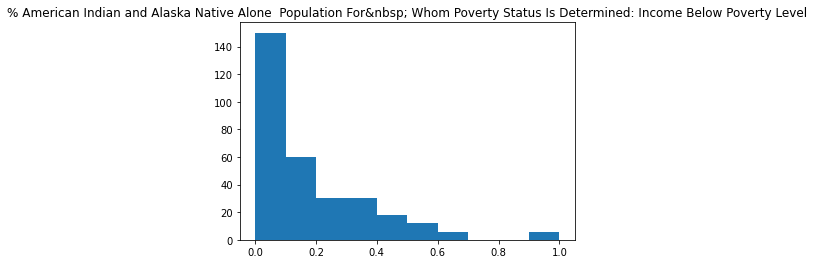

###### Transform
yeo-johnson: 0.3293099325931305
log: 1.256463784440039


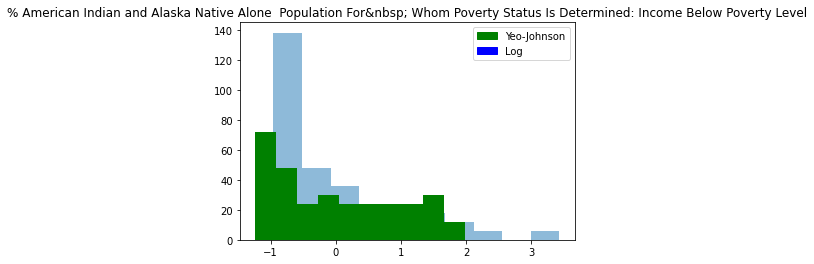

skewness: -1.3760996719514211


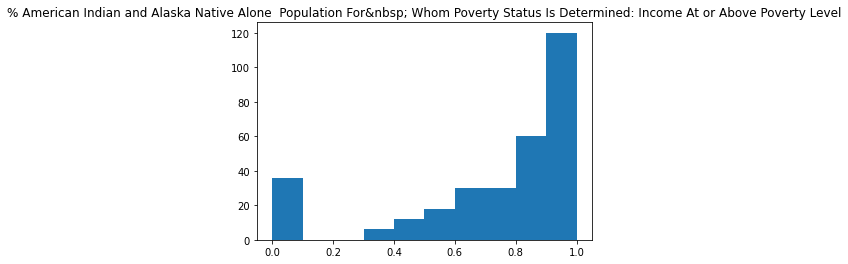

###### Transform
yeo-johnson: -0.4806784332130208
log: -1.6371939679354914


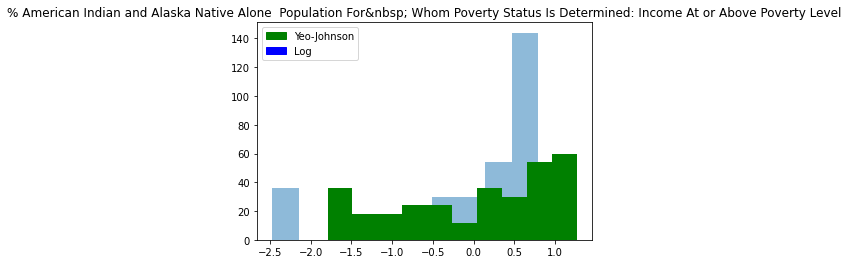

skewness: 2.512480997414018


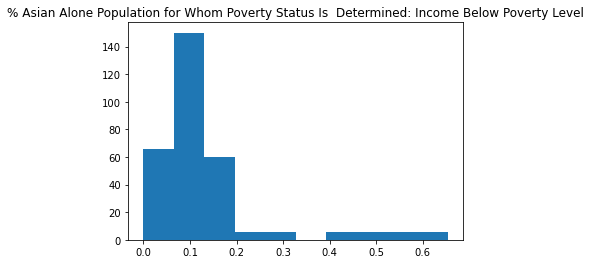

###### Transform
yeo-johnson: 0.06254544370438805
log: 2.1789334303208268


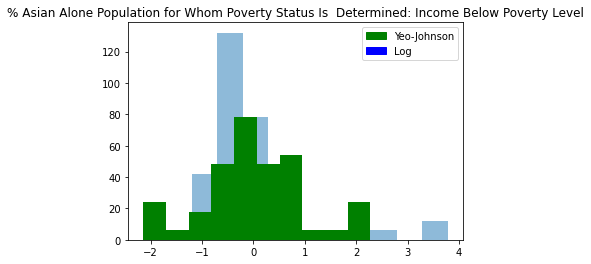

skewness: -2.512480997380814


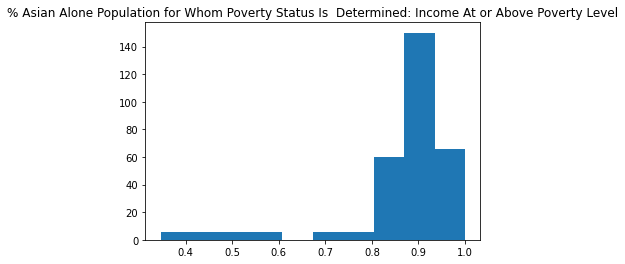

###### Transform
yeo-johnson: -0.1520363068914592
log: -2.7506172283225583


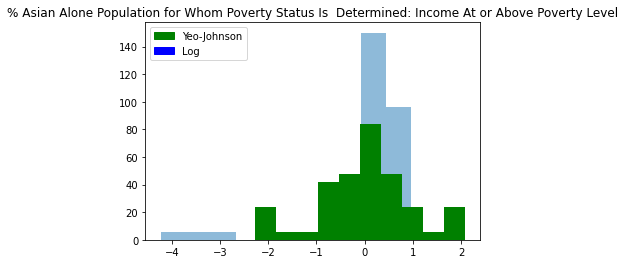

skewness: 2.2117672692275123


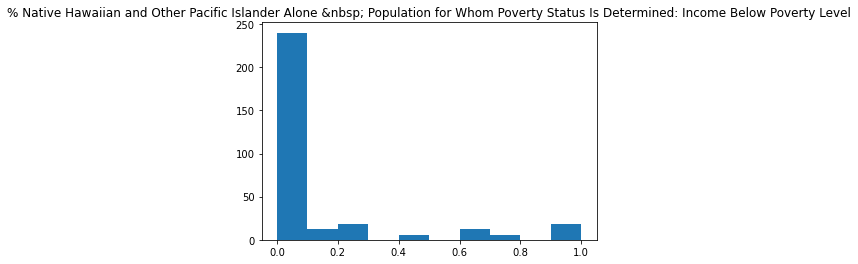

###### Transform
yeo-johnson: 1.1249018931167463
log: 2.019089793519941


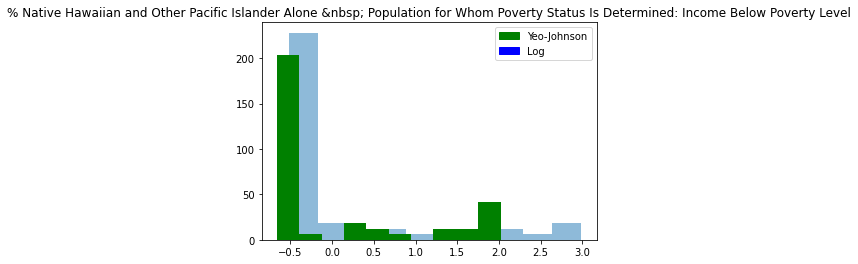

skewness: 2.3508460253556547


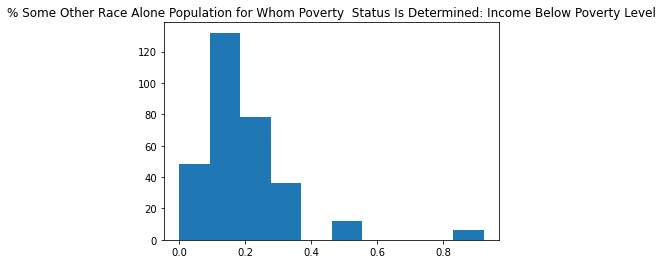

###### Transform
yeo-johnson: -0.05702577491806324
log: 1.4898459574435408


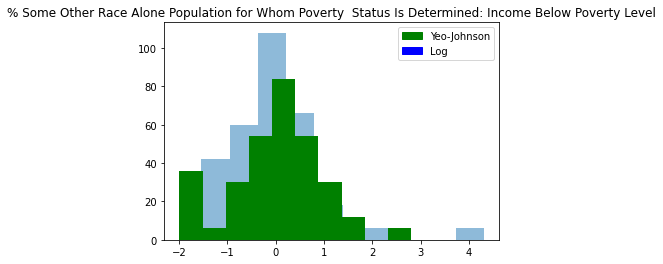

skewness: -2.350846025326737


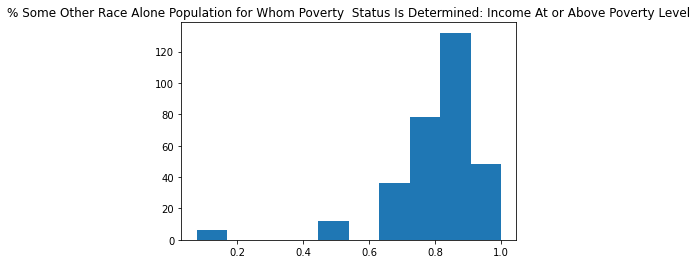

###### Transform
yeo-johnson: 0.027202419984609434
log: -3.2272819583004804


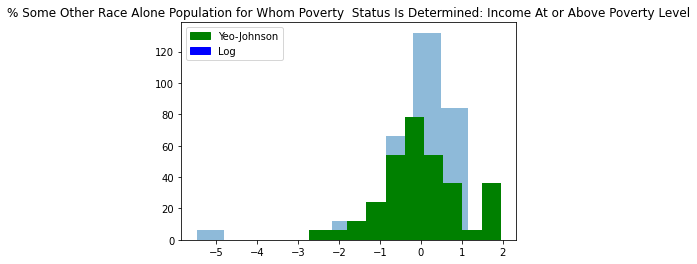

skewness: 1.3670821175700687


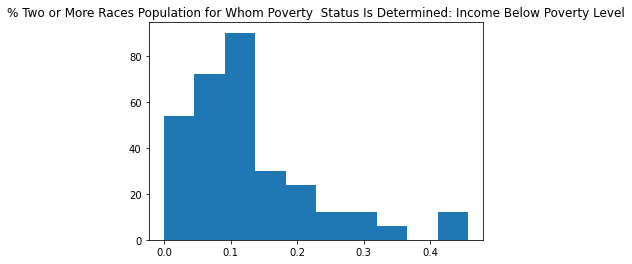

###### Transform
yeo-johnson: 0.09370862648495898
log: 1.1187044903390473


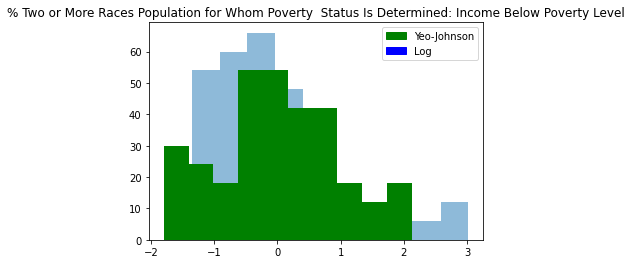

skewness: -1.3670821175696137


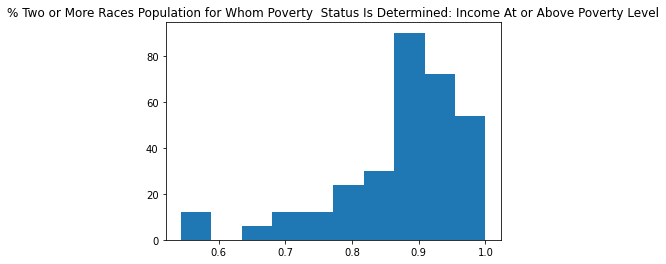

###### Transform
yeo-johnson: -0.1268166861431758
log: -1.539334149725539


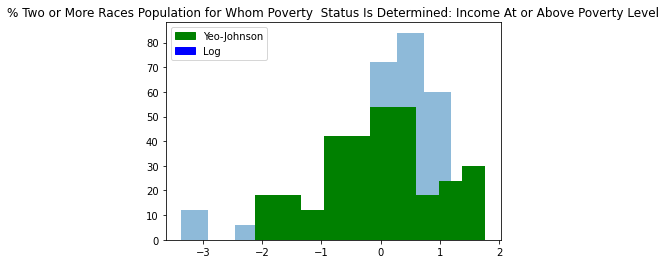

skewness: 1.4991033813498473


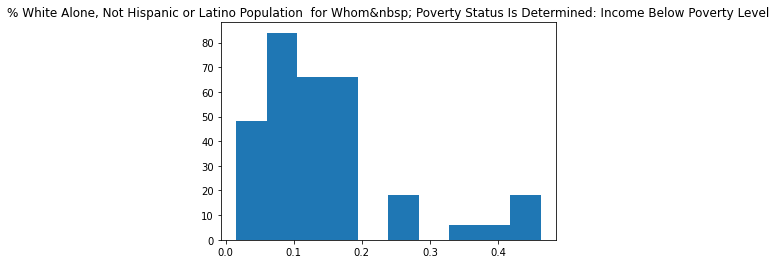

###### Transform
yeo-johnson: 0.15181925474414953
log: 1.288986823931248


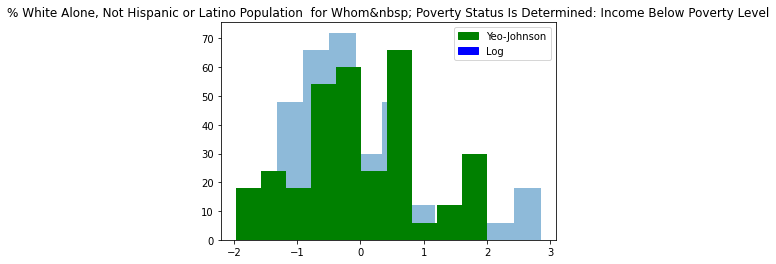

skewness: -1.4991033813022645


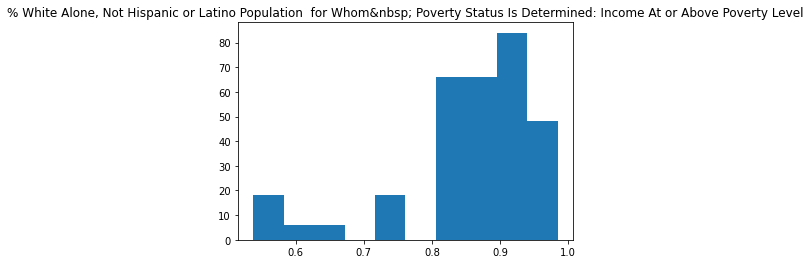

###### Transform
yeo-johnson: -0.19625871045252938
log: -1.6437894258720076


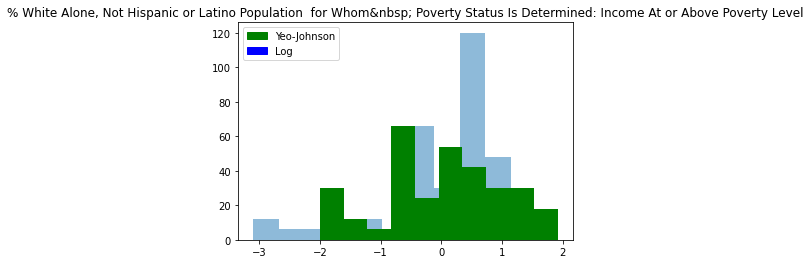

skewness: -1.853766207184588


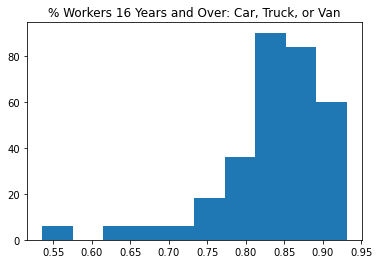

###### Transform
yeo-johnson: -0.13923647342884
log: -2.0499233627498725


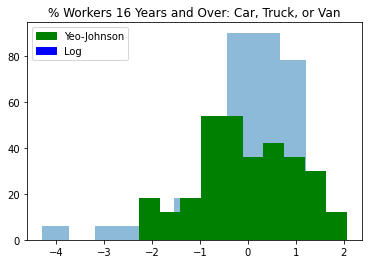

skewness: -1.4703533620756202


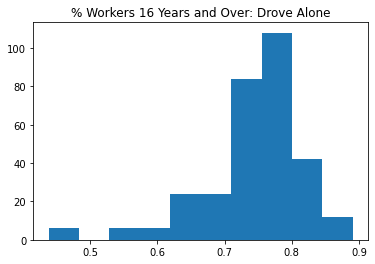

###### Transform
yeo-johnson: 0.040419415763271536
log: -1.7076510626192476


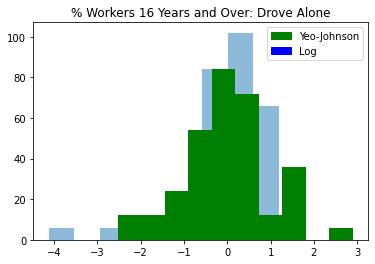

skewness: 2.2142023340153365


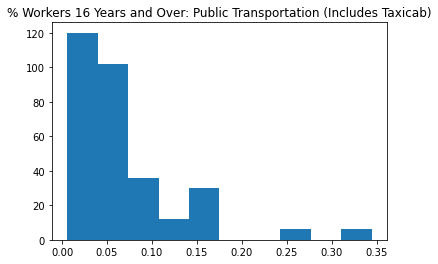

###### Transform
yeo-johnson: 0.2845226041482766
log: 1.973773860656371


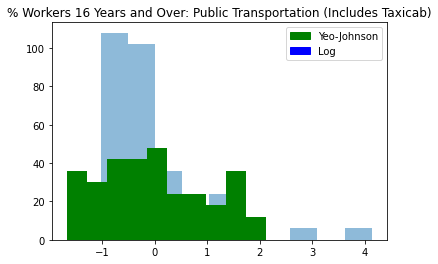

skewness: 2.807157435206168


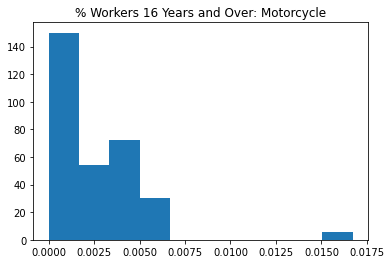

###### Transform
yeo-johnson: 0.0
log: 2.782512422028537


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


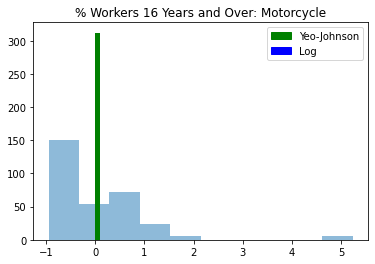

skewness: 2.690320315158626


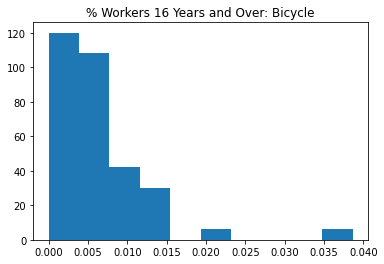

###### Transform
yeo-johnson: 0.0
log: 2.64124068239341


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


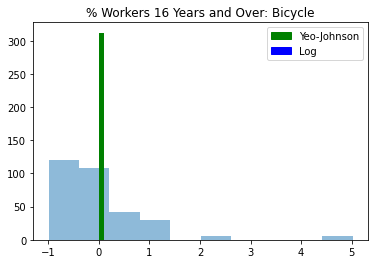

skewness: 2.0367051836764127


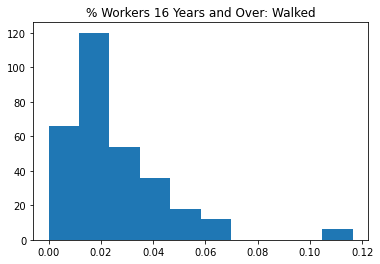

###### Transform
yeo-johnson: 0.0
log: 1.920667794449904


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


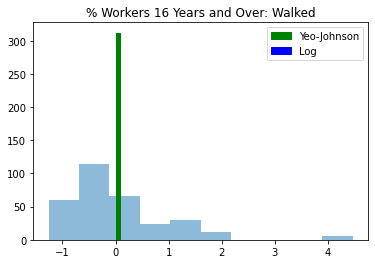

skewness: 1.493485655958176


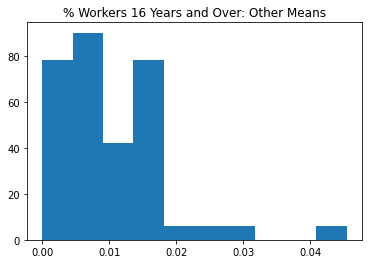

###### Transform
yeo-johnson: 0.0
log: 1.4496135405819233


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


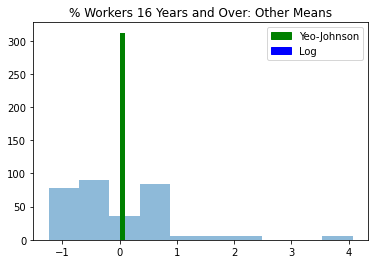

skewness: 2.5833754559930484


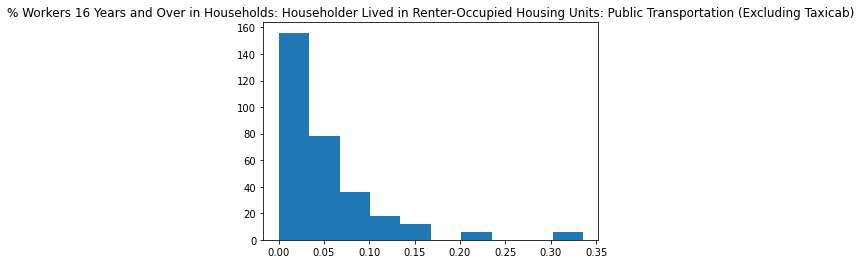

###### Transform
yeo-johnson: 0.3450181990348912
log: 2.316830620095393


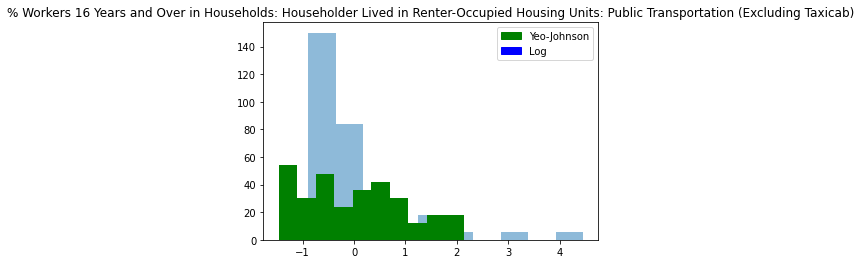

skewness: 2.6617268996264185


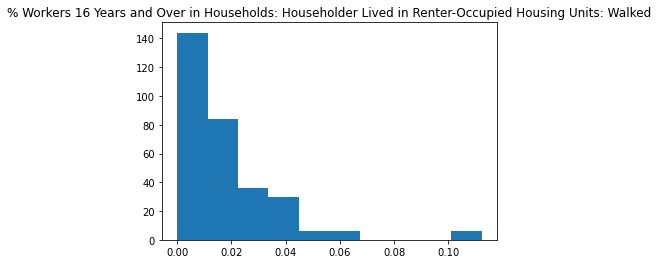

###### Transform
yeo-johnson: 0.0
log: 2.5301425765325365


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


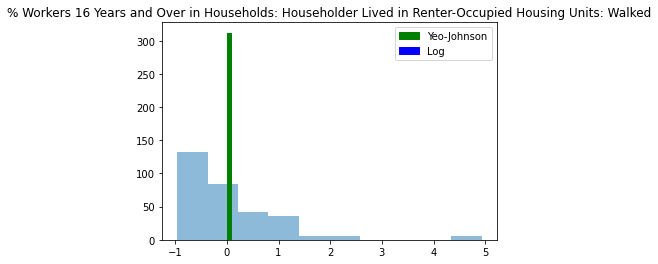

skewness: 1.111163578084888


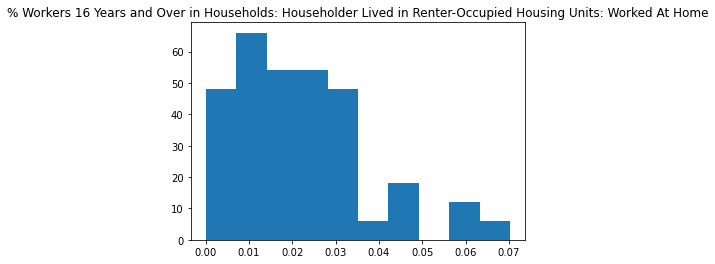

###### Transform
yeo-johnson: 0.0
log: 1.0654822447792793


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


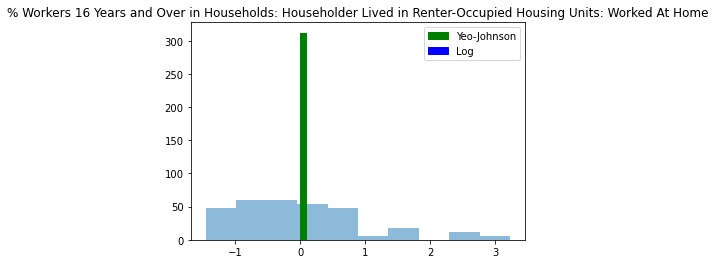

skewness: 1.0164153769469566


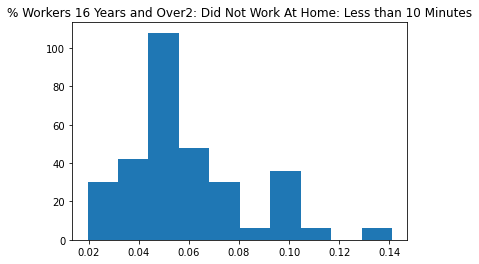

###### Transform
yeo-johnson: 0.0
log: 0.9490283458461045


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


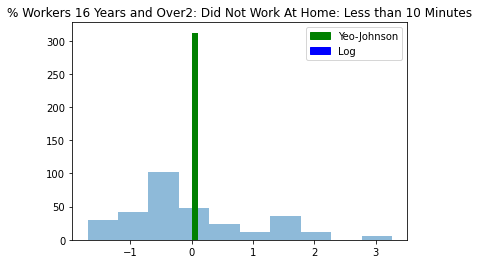

skewness: 3.6806305634652414


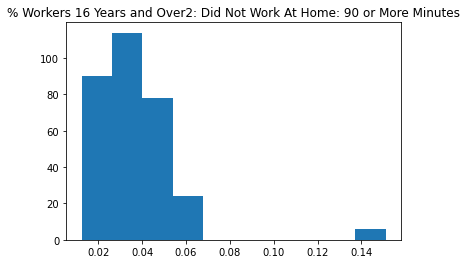

###### Transform
yeo-johnson: 0.0
log: 3.4790921015742846


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


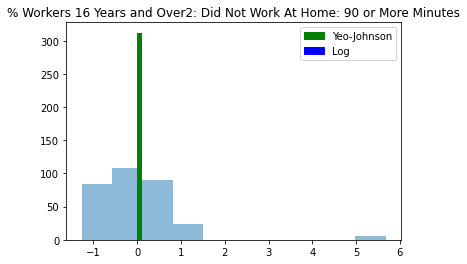

skewness: 1.3707967063767503


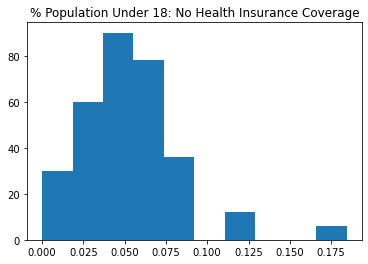

###### Transform
yeo-johnson: -0.05321472050772223
log: 1.1848853468152003


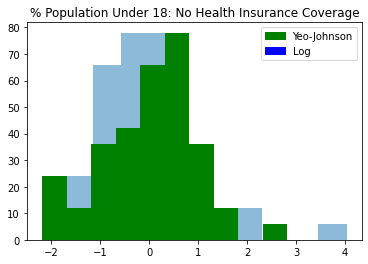

skewness: -1.3707967067732092


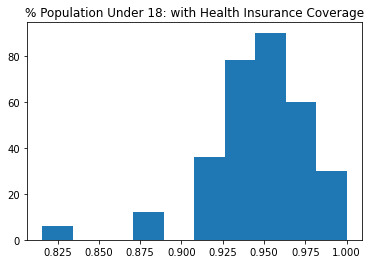

###### Transform
yeo-johnson: 0.05434498420684168
log: -1.480422226828938


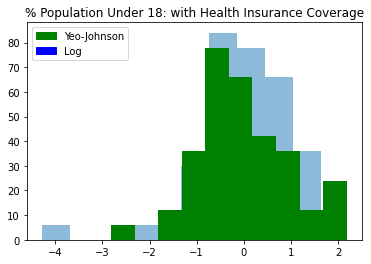

skewness: 1.7482035500942799


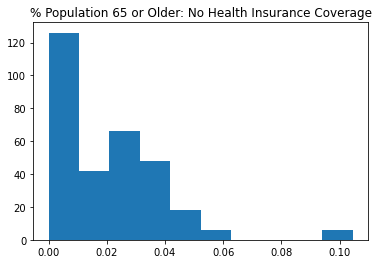

###### Transform
yeo-johnson: 0.0
log: 1.635850651105895


/Users/jackiedong/opt/anaconda3/envs/CSCI-499/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


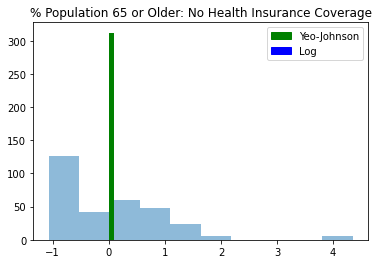

skewness: -1.7482035499727082


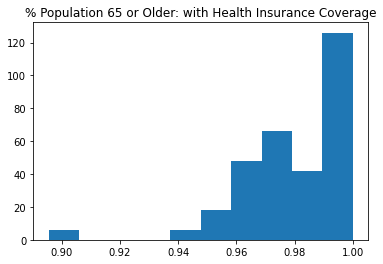

###### Transform
yeo-johnson: -0.15350165017835316
log: -1.8106053439653733


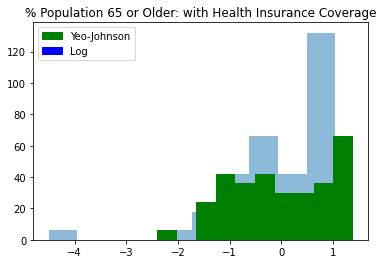

skewness: 1.4265777507842892


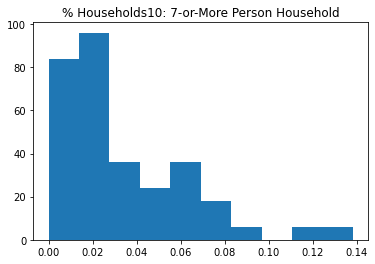

###### Transform
yeo-johnson: 0.20207215126391004
log: 1.3415518969927087


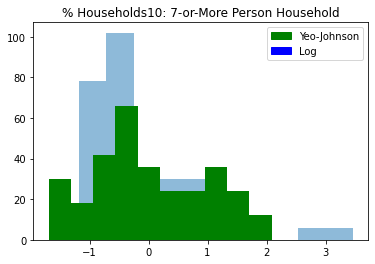

In [97]:
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
        t1 = scale(power_transform(feat.reshape(-1,1)))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


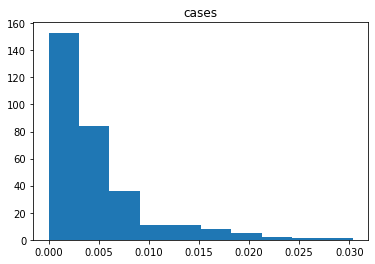

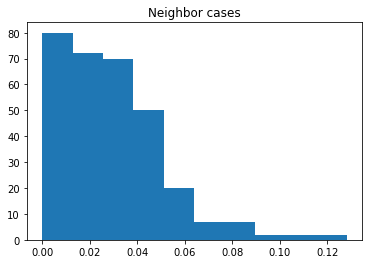

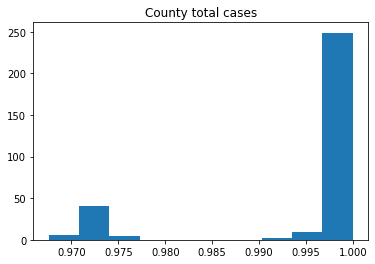

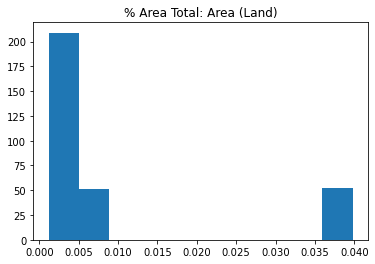

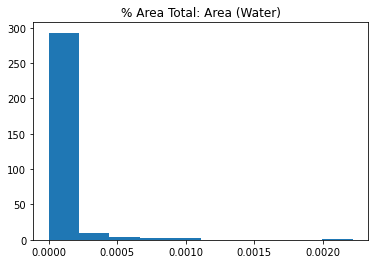

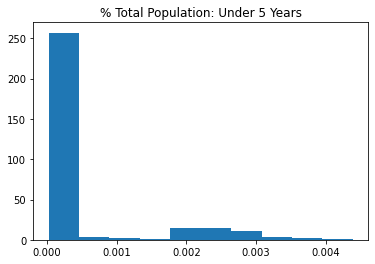

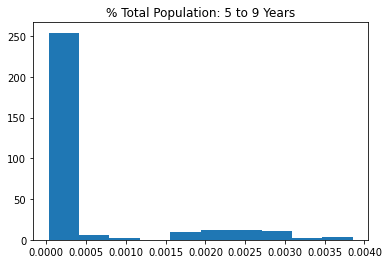

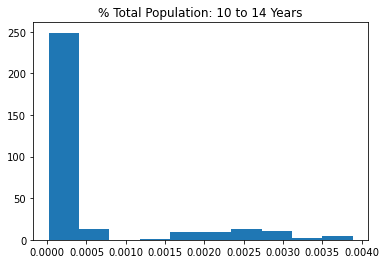

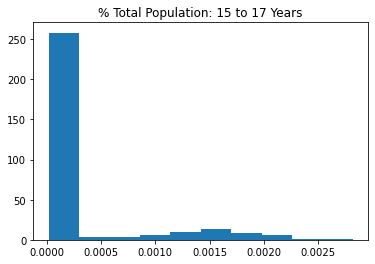

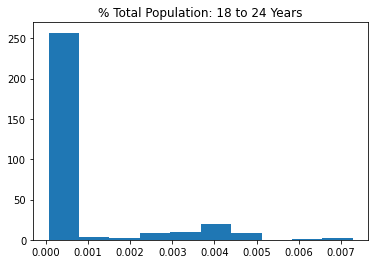

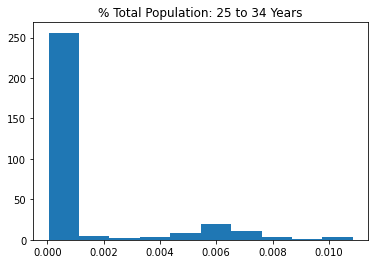

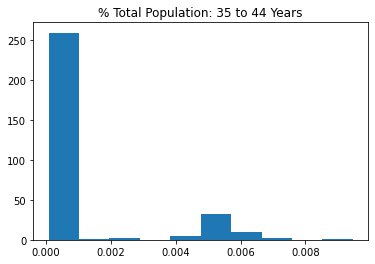

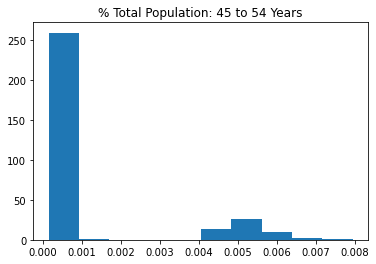

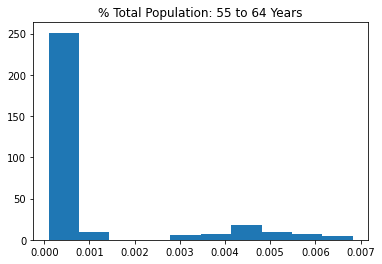

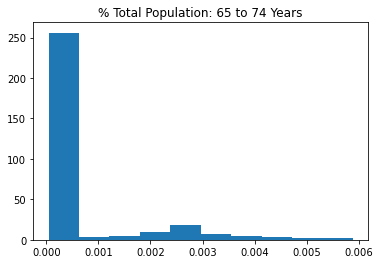

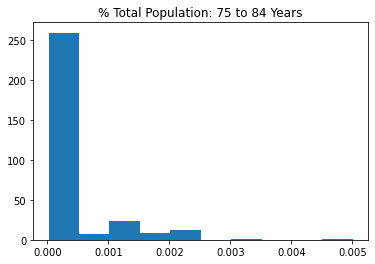

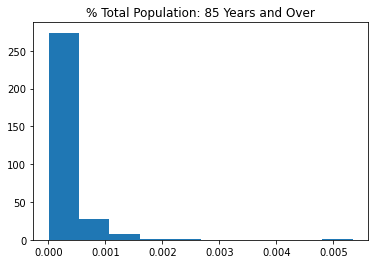

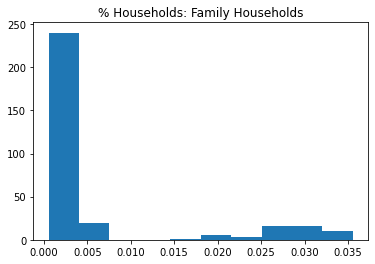

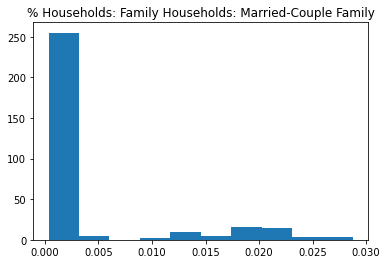

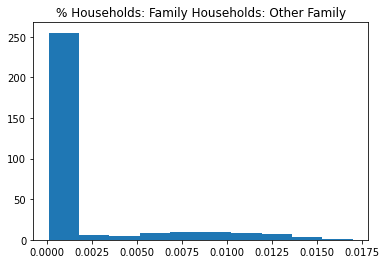

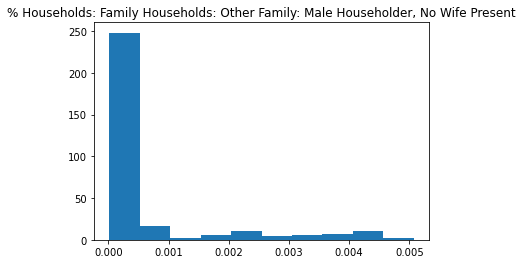

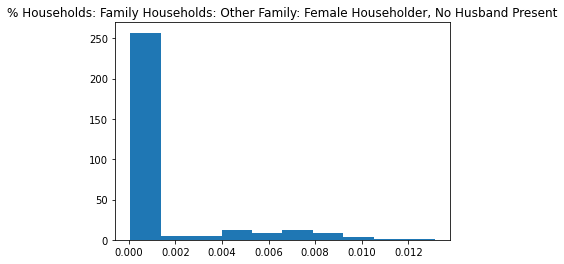

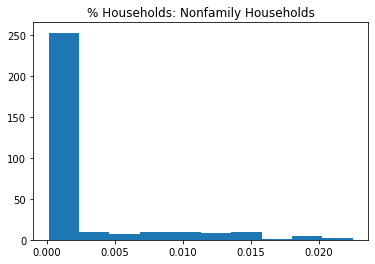

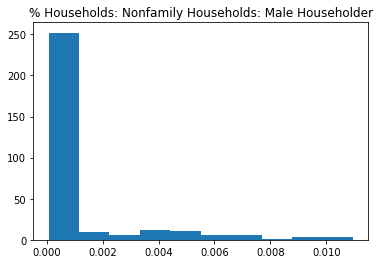

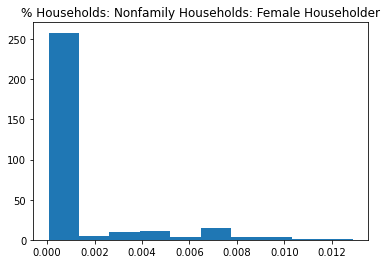

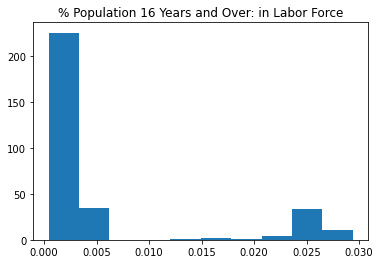

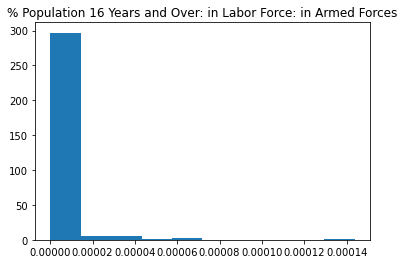

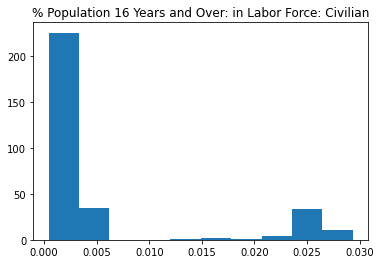

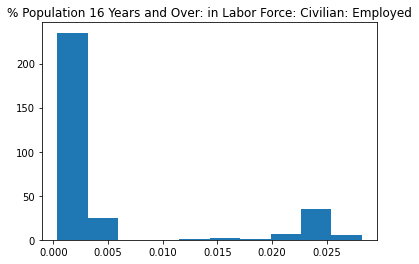

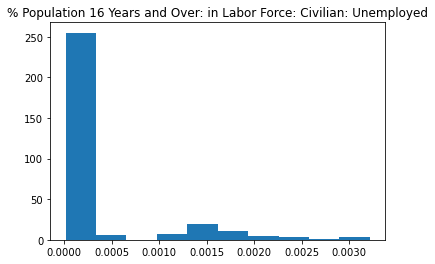

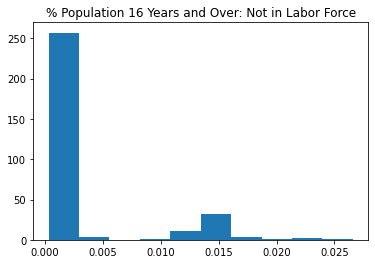

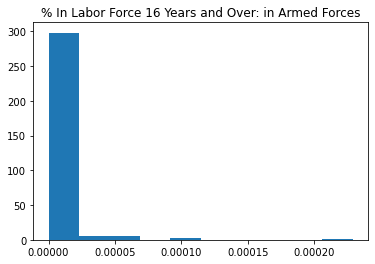

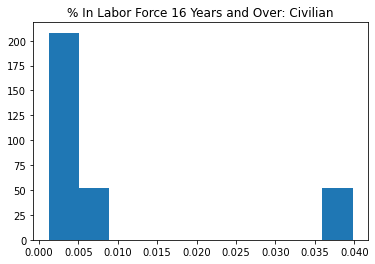

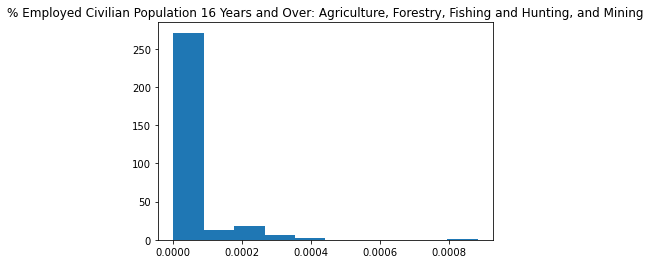

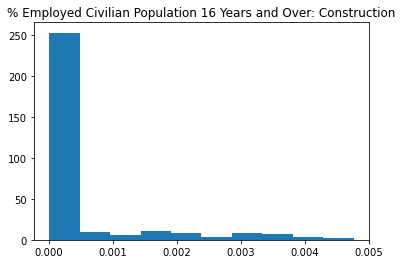

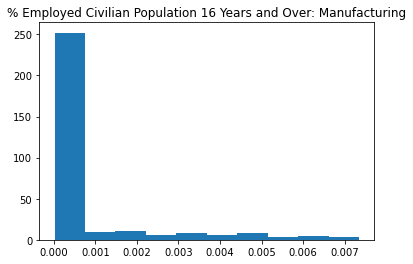

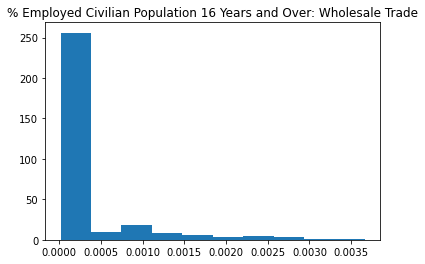

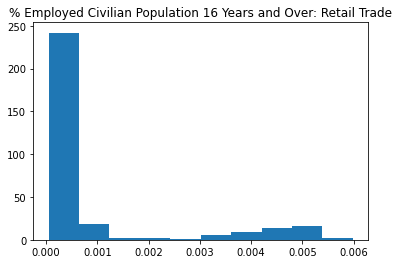

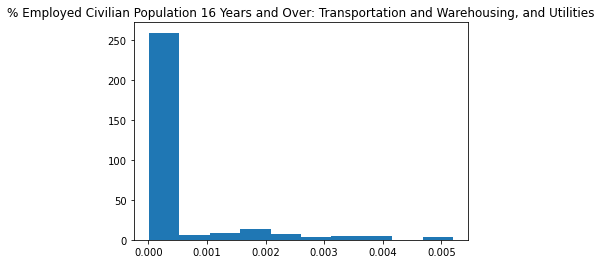

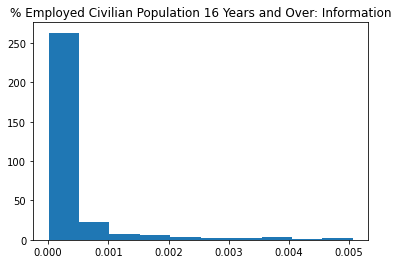

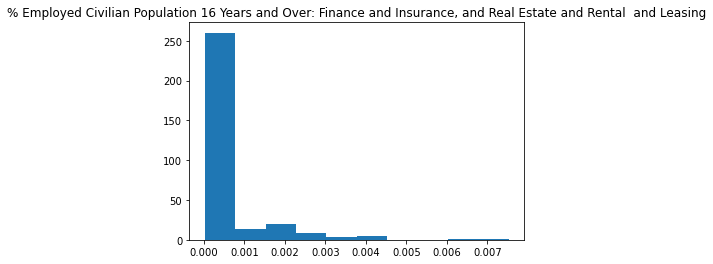

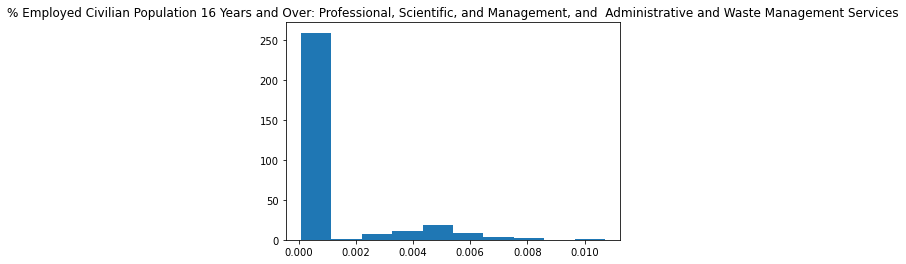

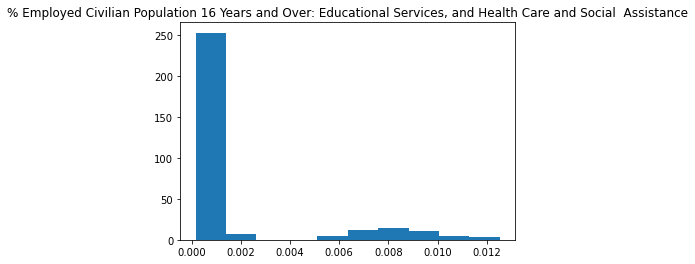

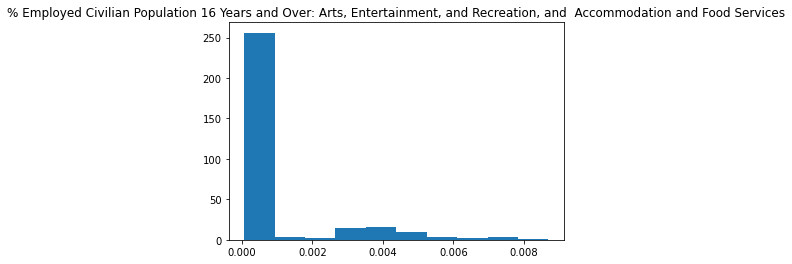

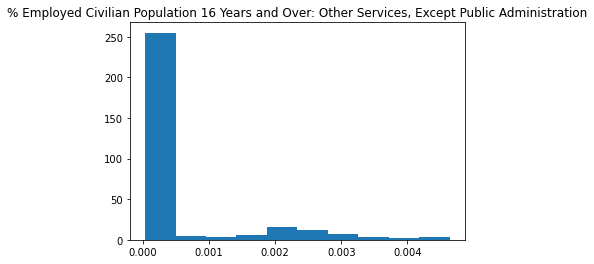

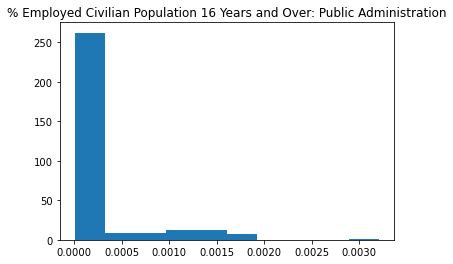

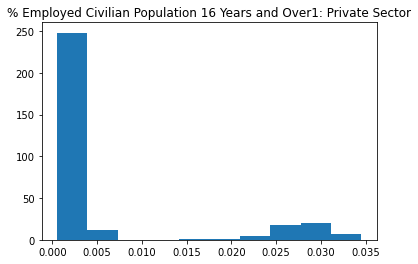

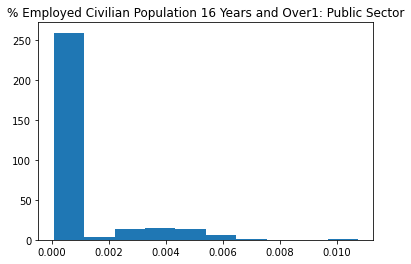

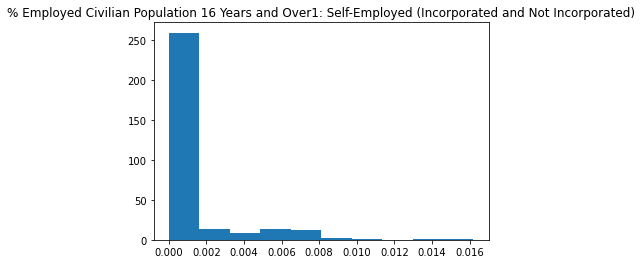

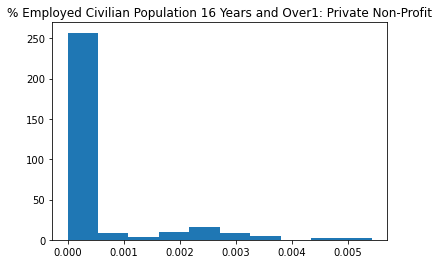

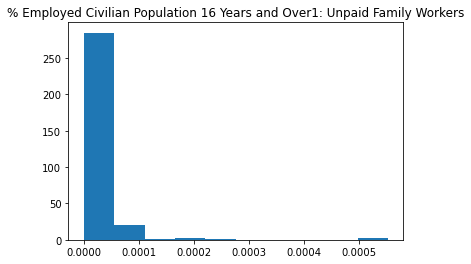

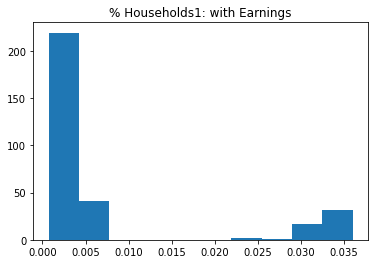

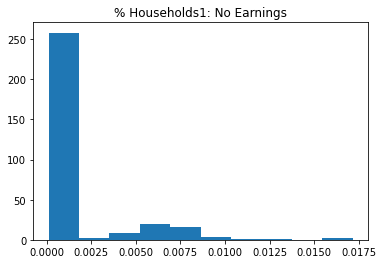

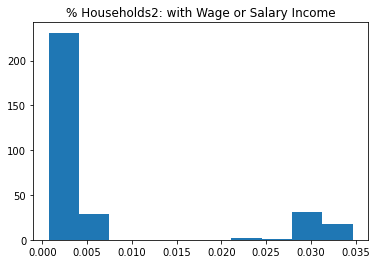

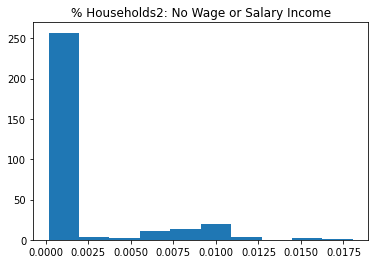

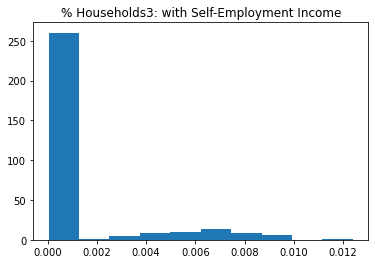

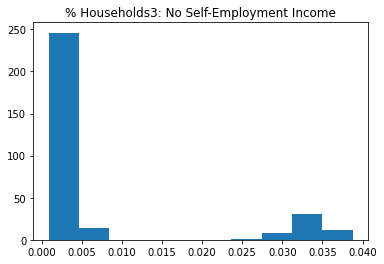

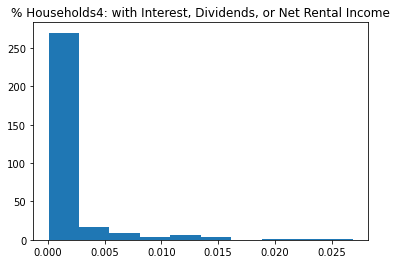

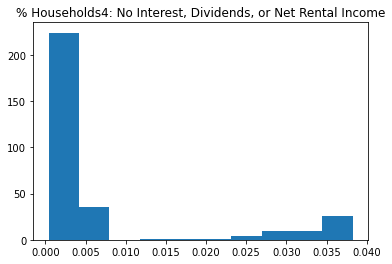

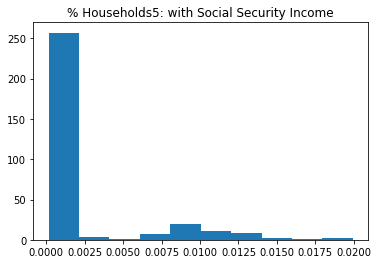

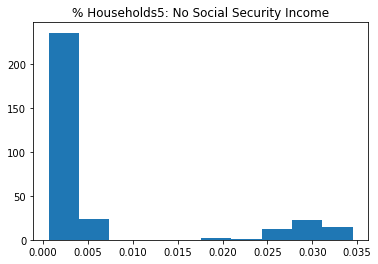

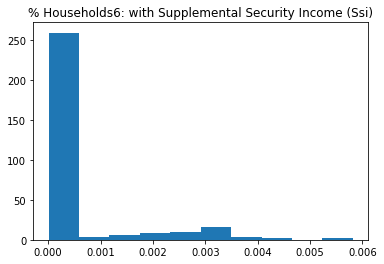

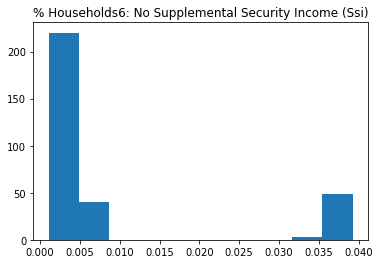

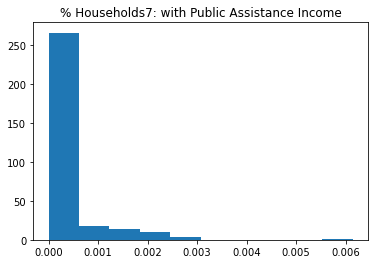

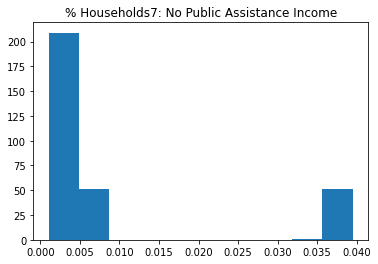

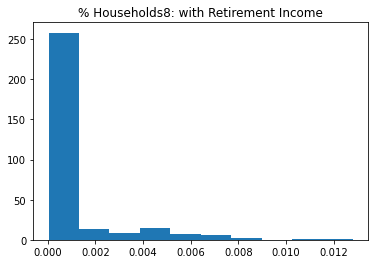

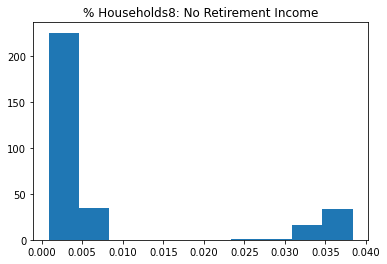

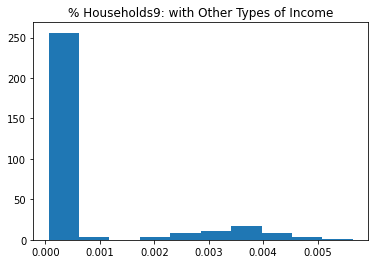

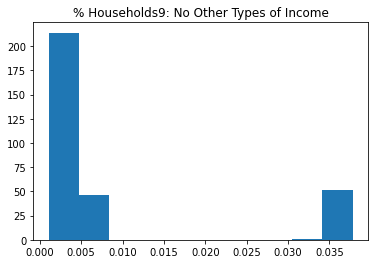

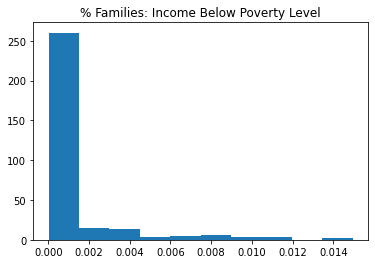

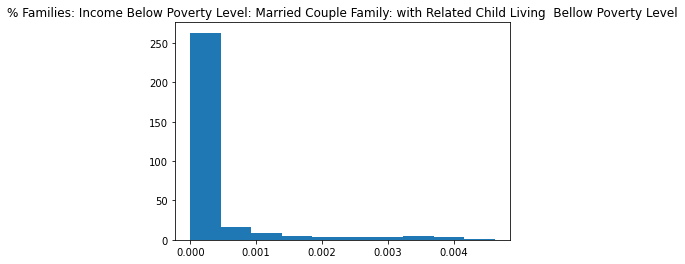

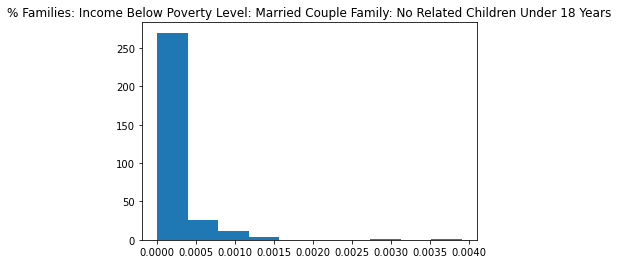

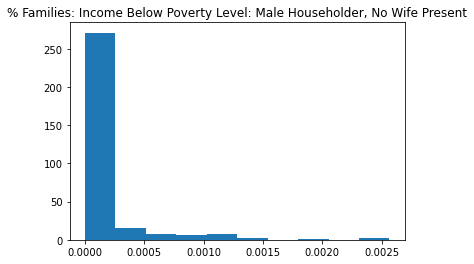

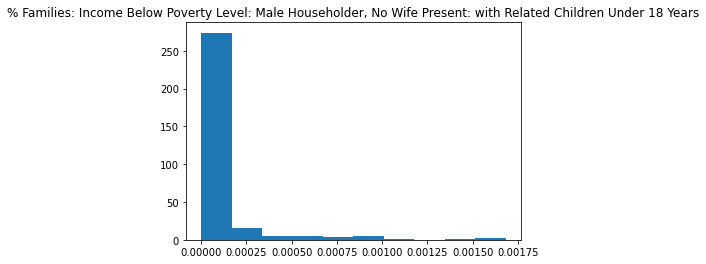

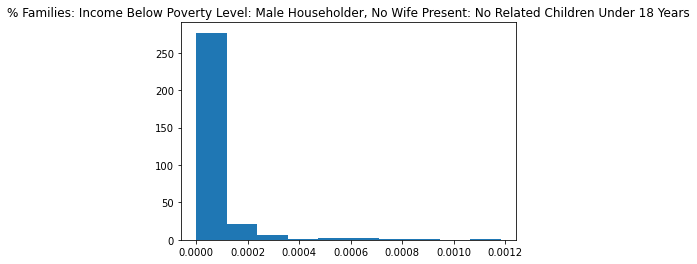

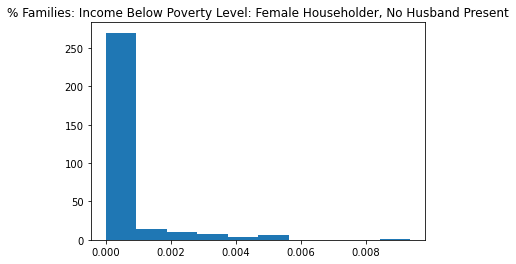

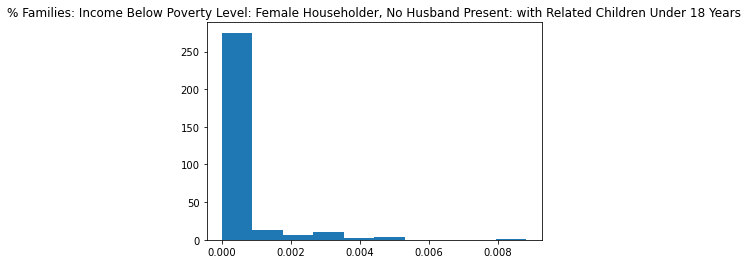

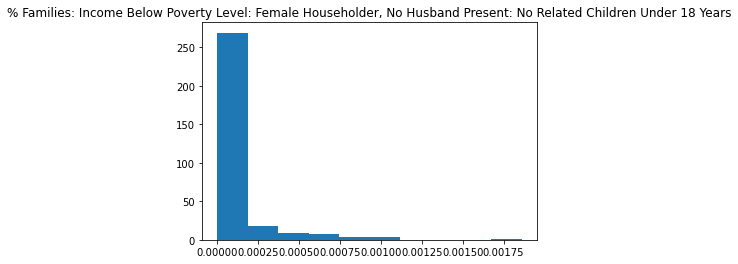

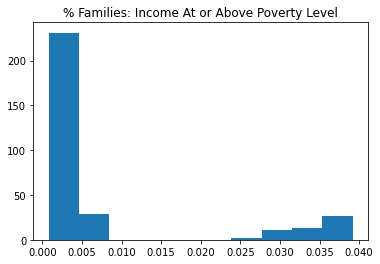

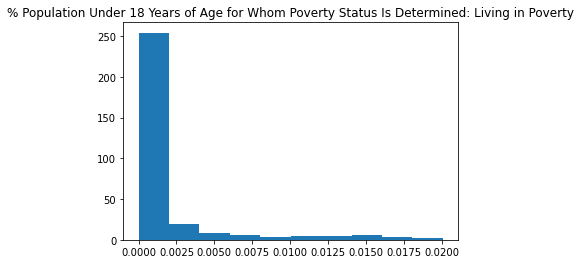

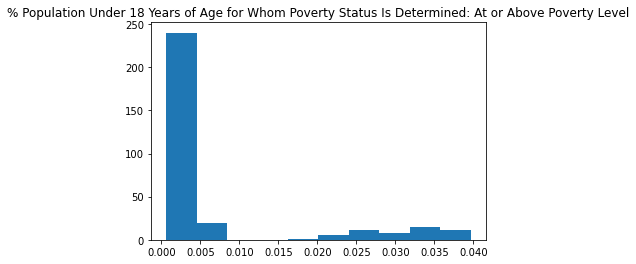

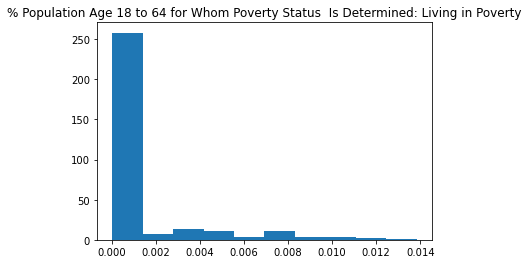

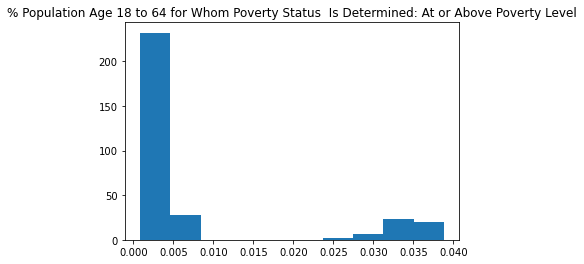

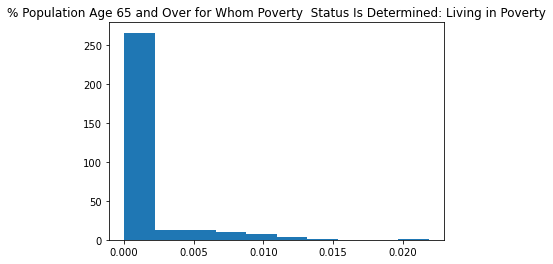

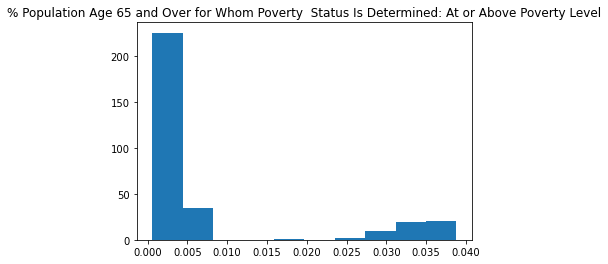

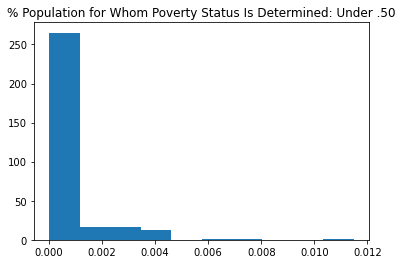

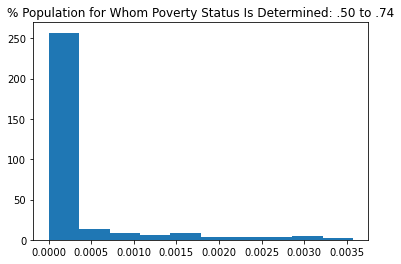

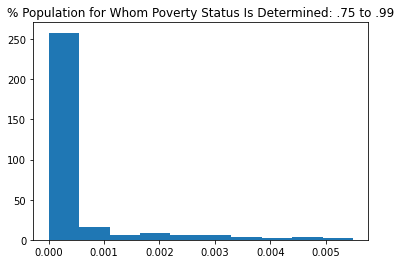

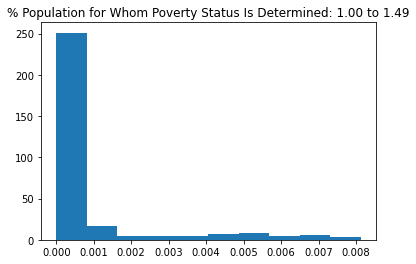

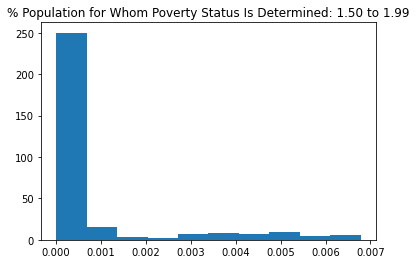

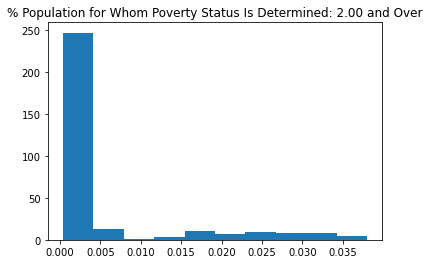

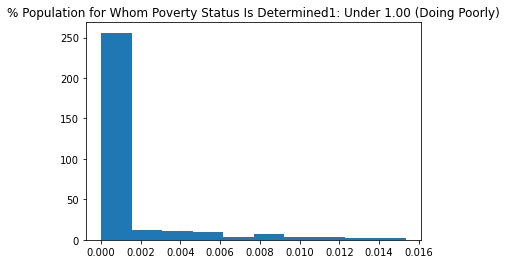

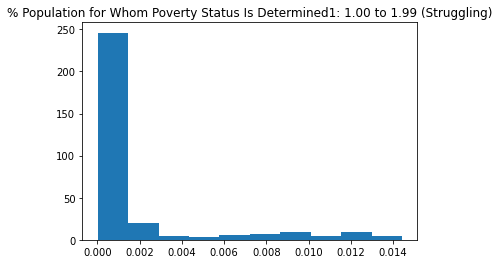

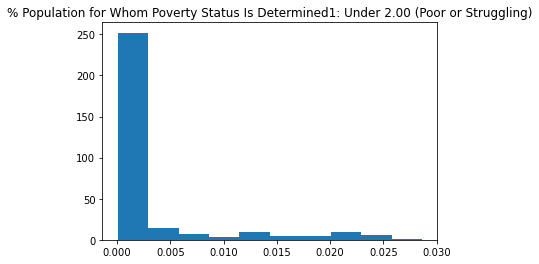

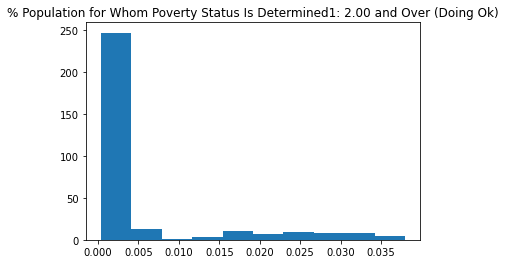

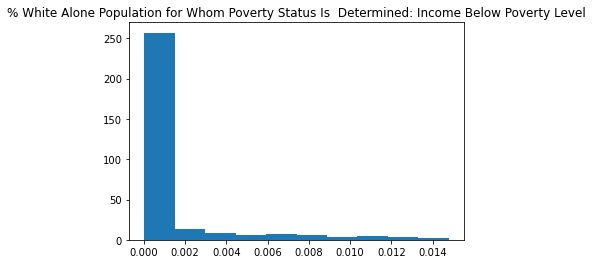

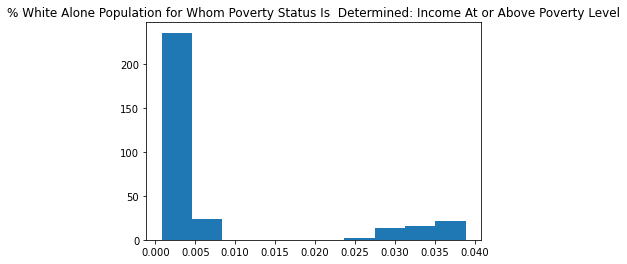

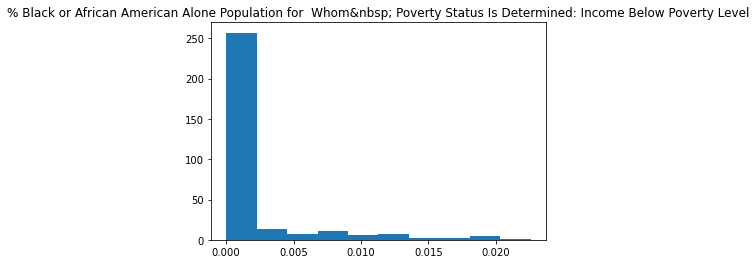

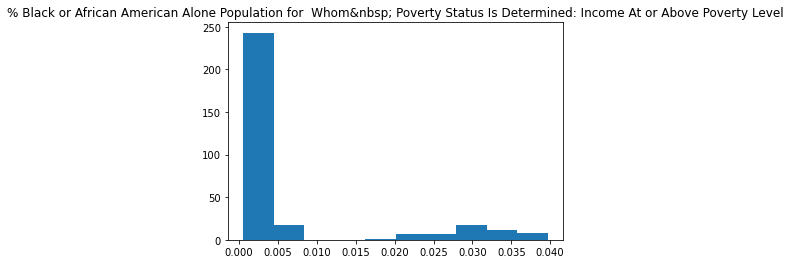

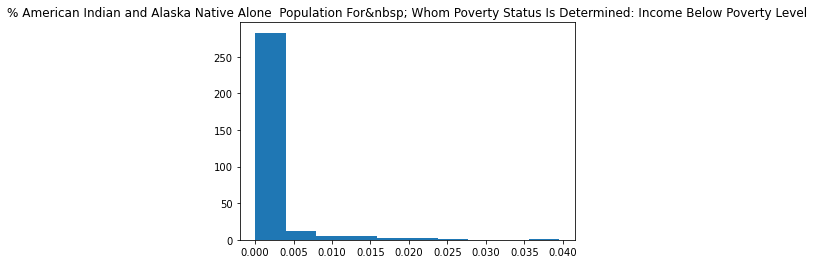

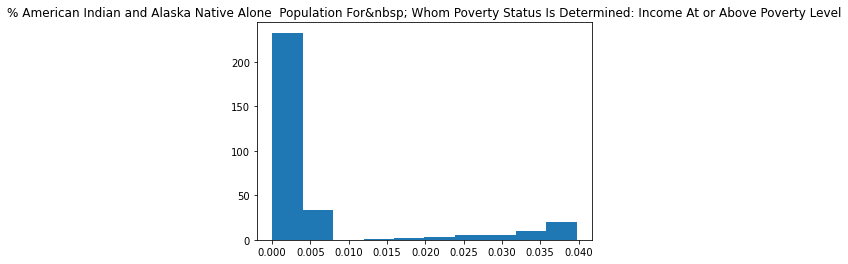

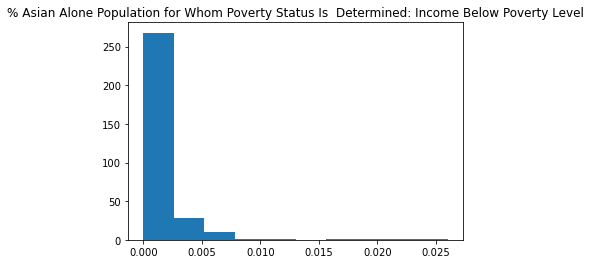

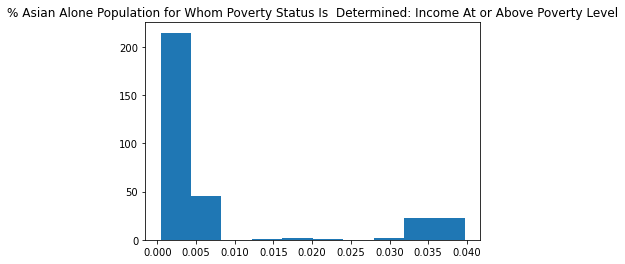

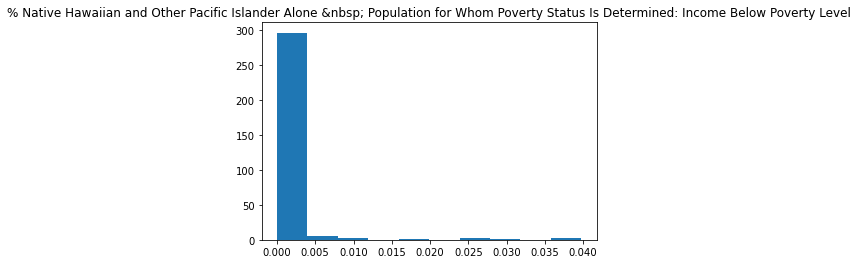

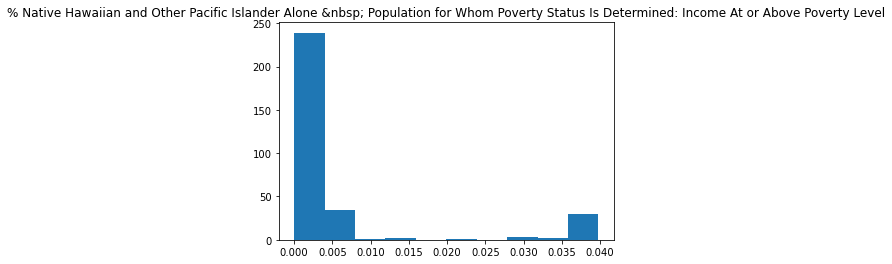

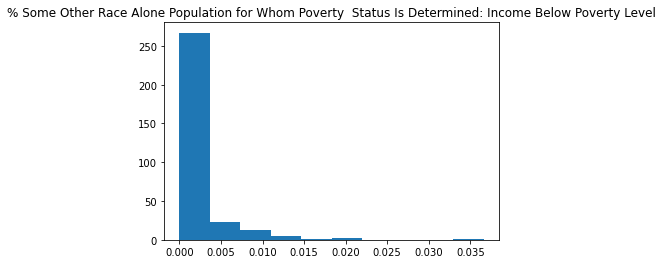

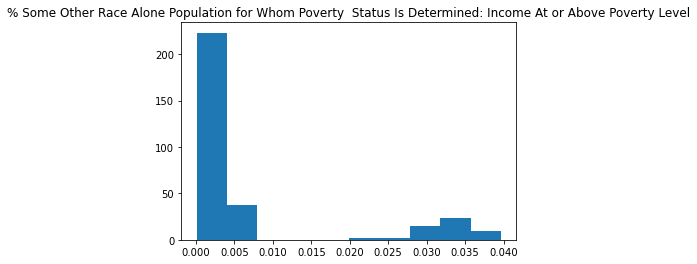

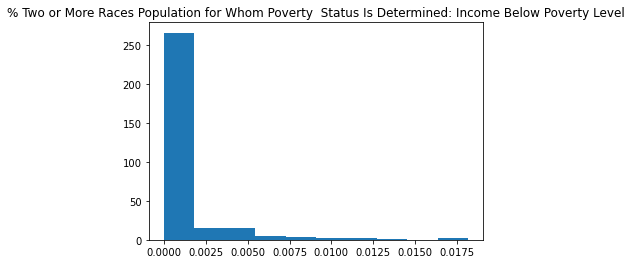

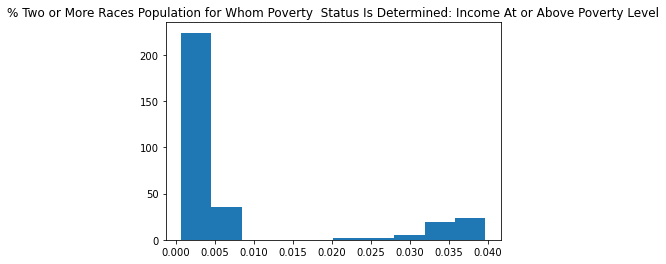

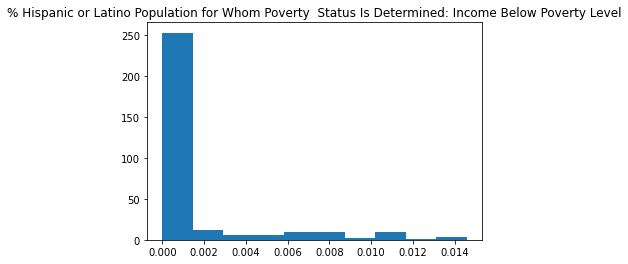

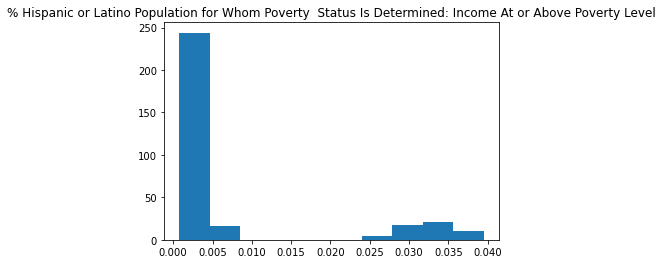

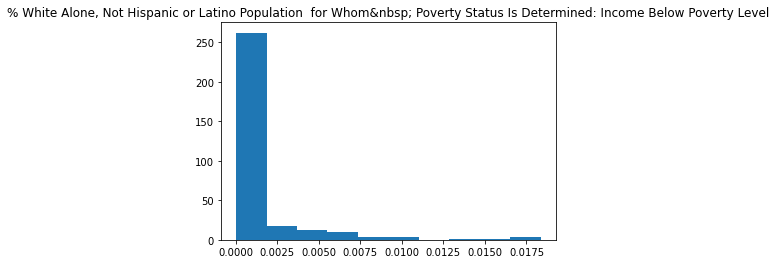

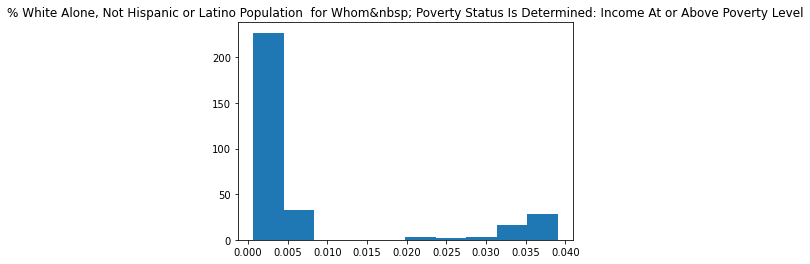

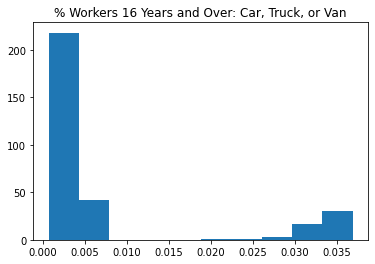

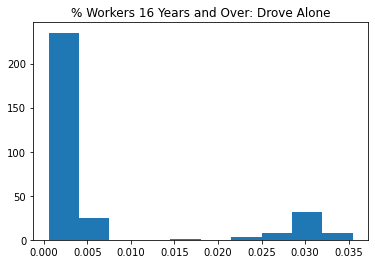

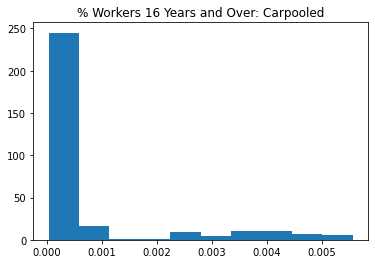

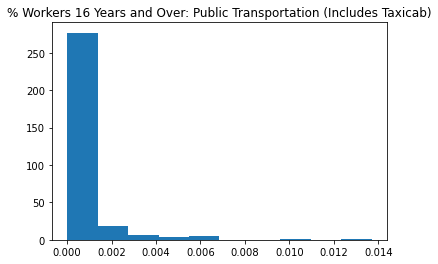

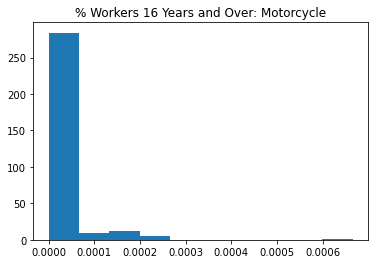

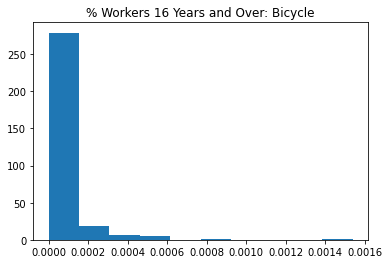

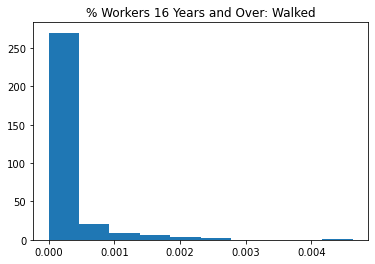

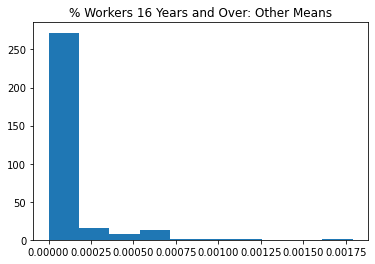

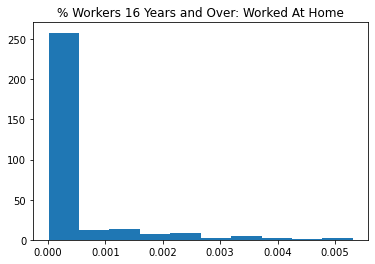

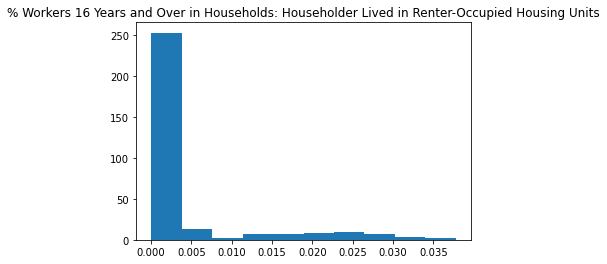

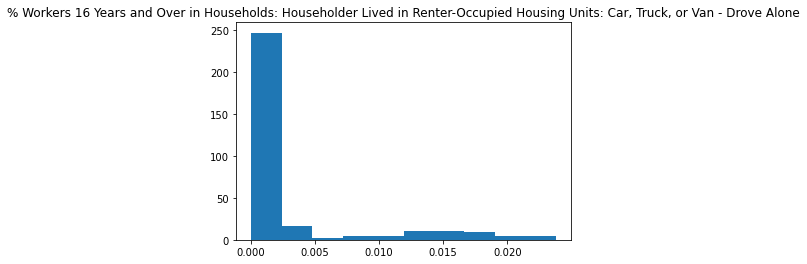

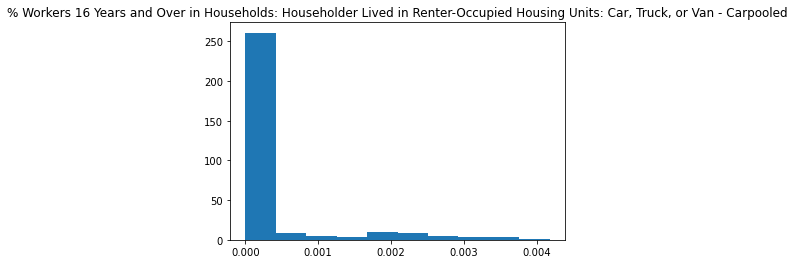

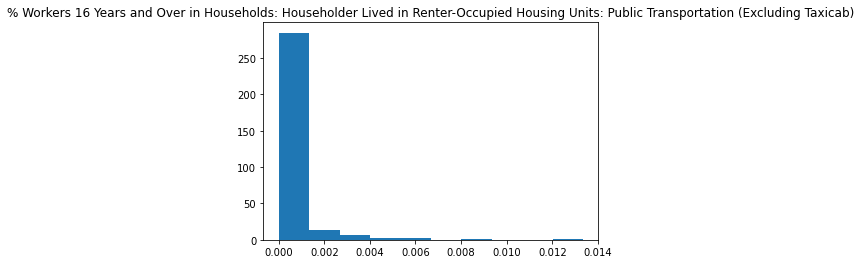

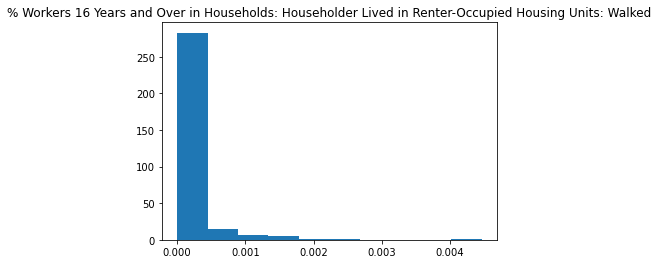

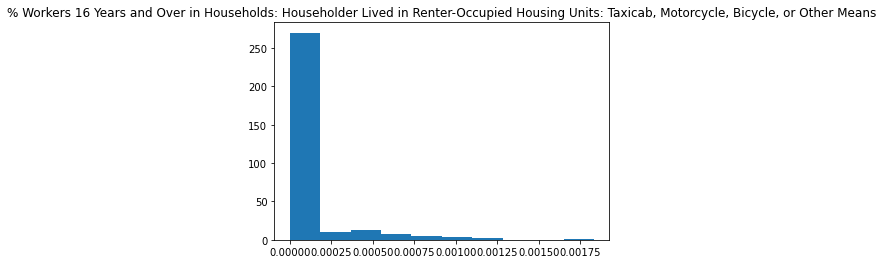

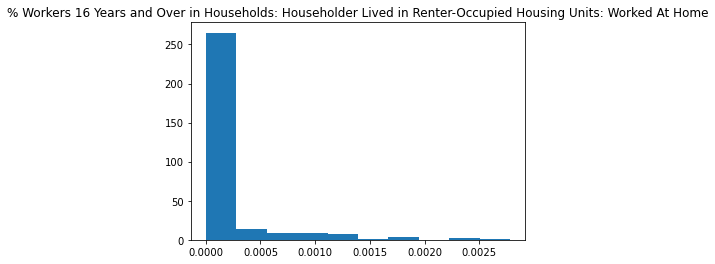

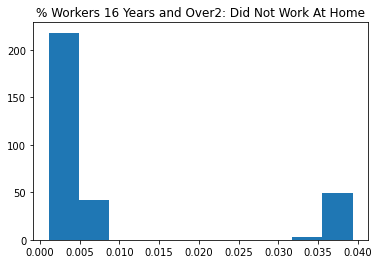

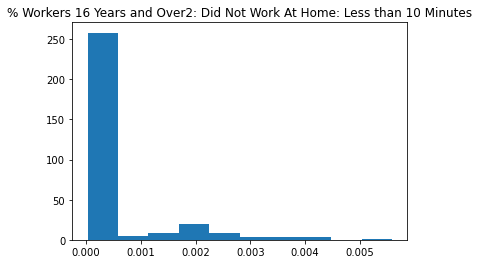

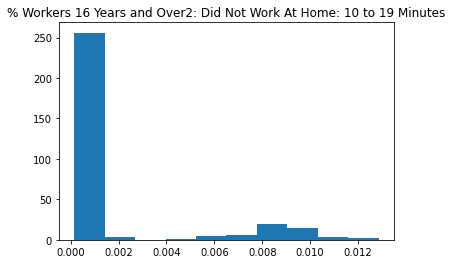

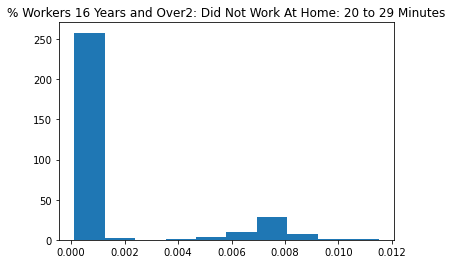

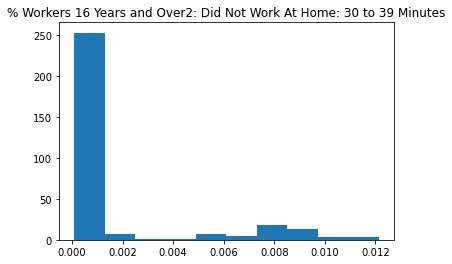

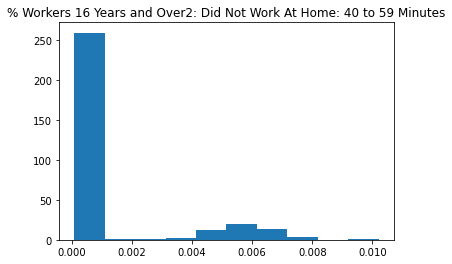

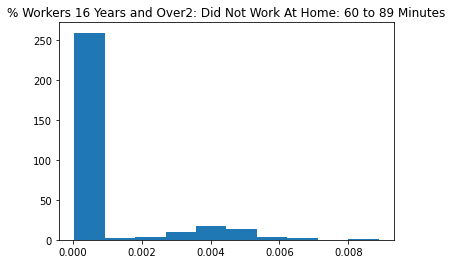

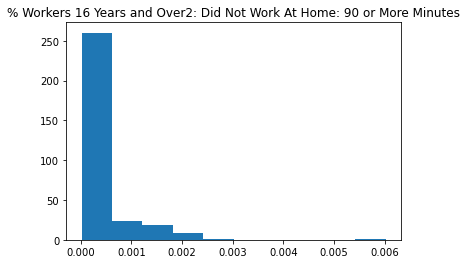

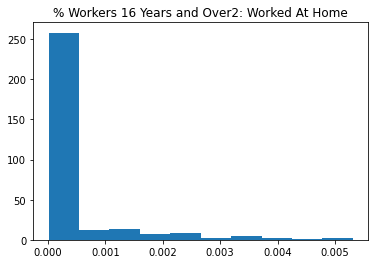

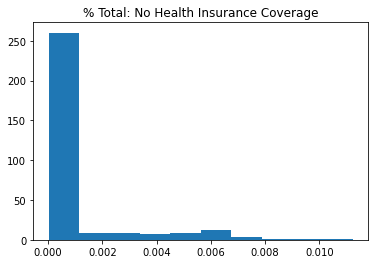

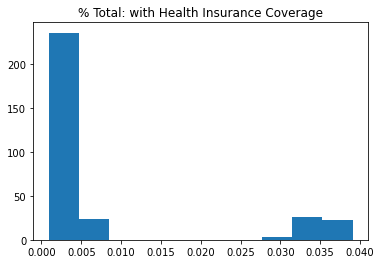

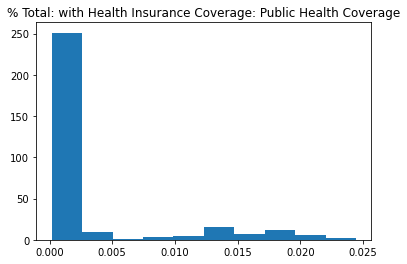

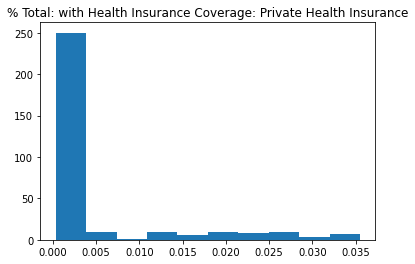

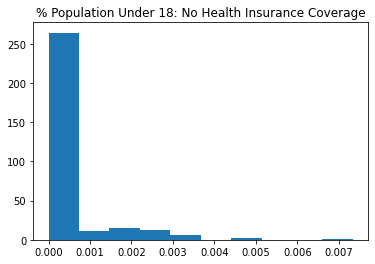

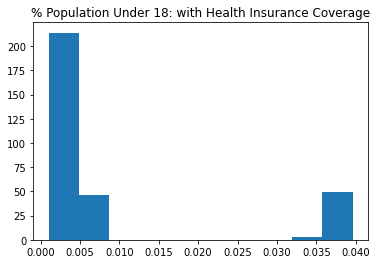

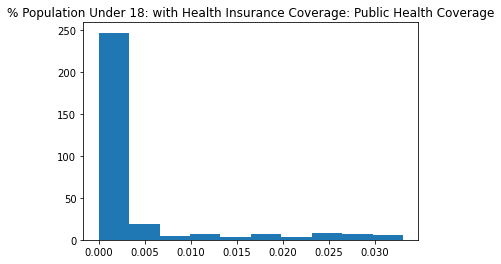

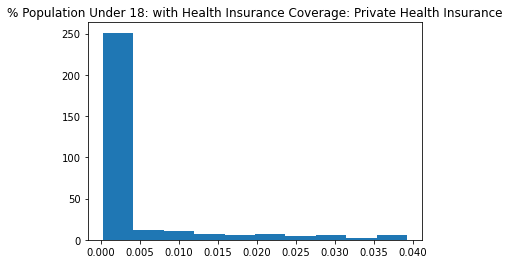

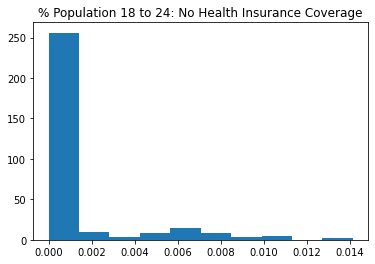

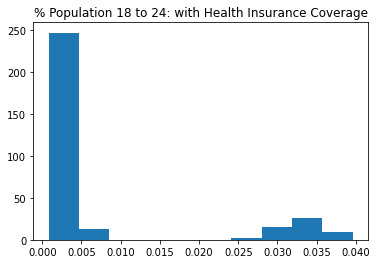

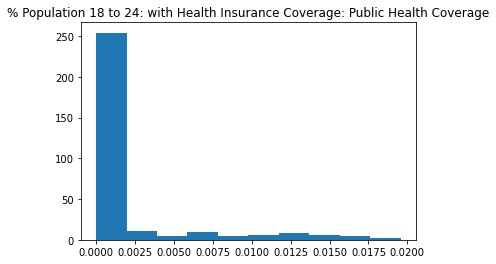

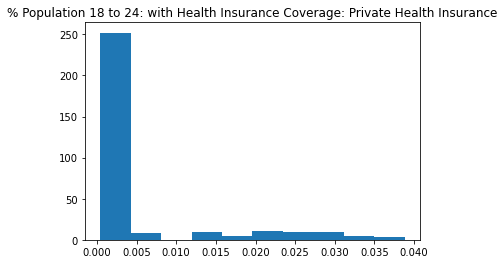

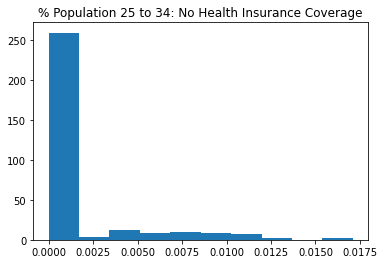

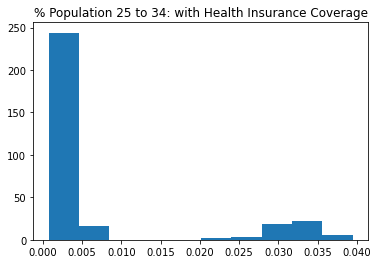

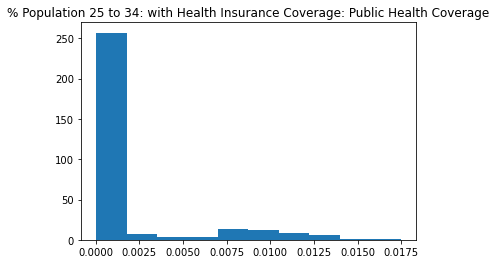

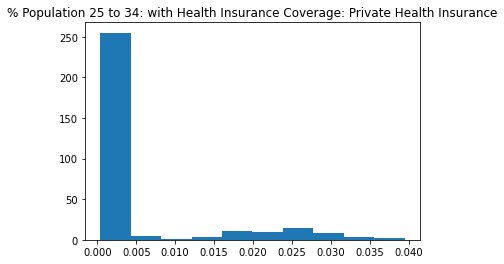

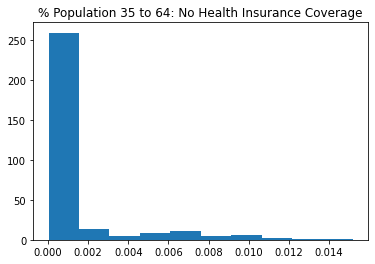

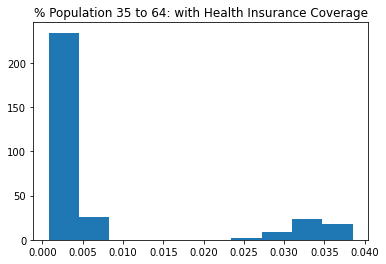

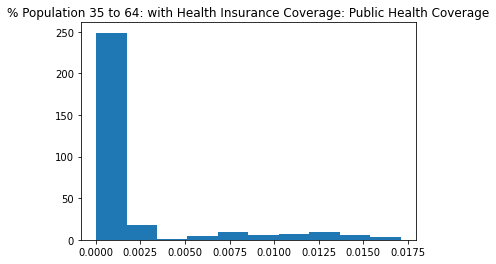

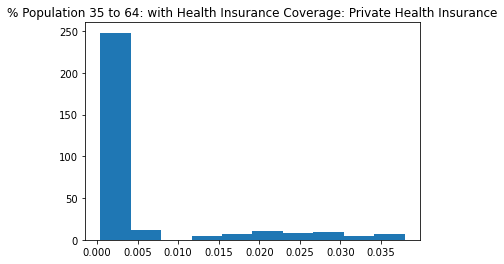

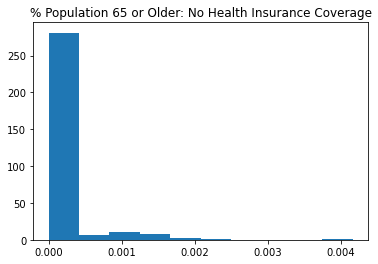

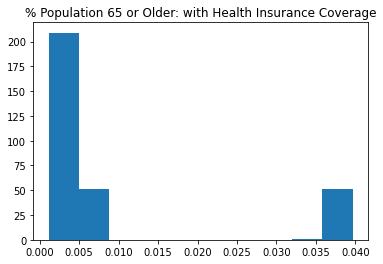

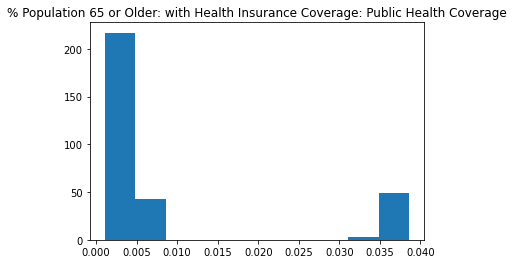

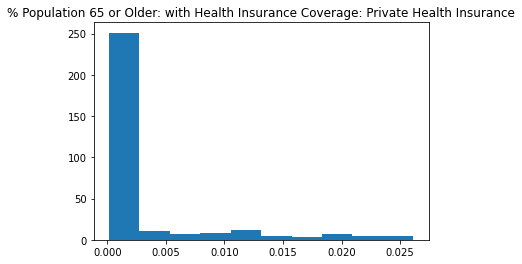

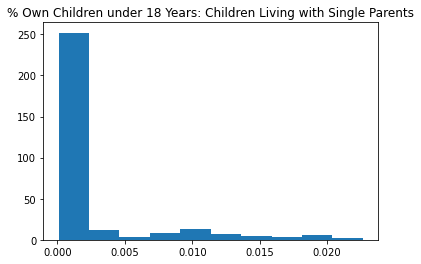

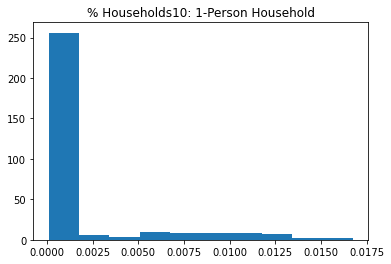

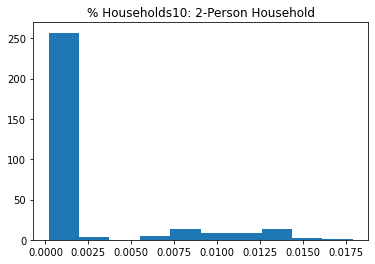

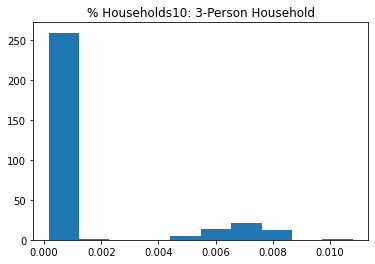

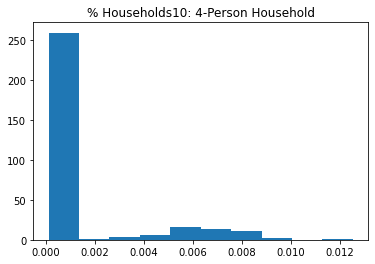

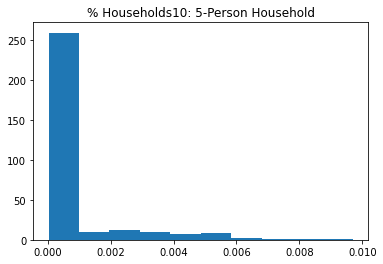

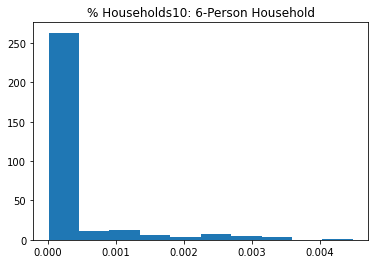

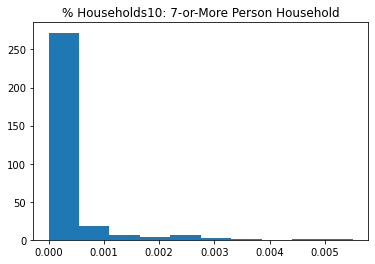

In [286]:
for i in range(1, month_data_with_census.shape[1]-1):
    plt.hist(month_data_with_census[:,i])
    plt.title(feature_names[i-1])
    plt.show()